导入包

In [1]:
library(rugarch)
library(VineCopula)
library(fGarch) 
library(quantreg)
library(readxl)
library(xts)
library(ggplot2)
library(tidyr)
library(moments)
library(tseries)
library(FinTS)
library(GGally)
library(gridExtra)
library(ggplotify)
library(ggpubr)
library(grid)
library(mistr)

Loading required package: parallel


Attaching package: 'rugarch'


The following object is masked from 'package:stats':

    sigma


NOTE: Packages 'fBasics', 'timeDate', and 'timeSeries' are no longer
attached to the search() path when 'fGarch' is attached.

If needed attach them yourself in your R script by e.g.,
        require("timeSeries")

Loading required package: SparseM


Attaching package: 'SparseM'


The following object is masked from 'package:base':

    backsolve


Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2


Attaching package: 'mistr'


The following object is masked from 'package:base':

    q




In [2]:
data<- read_excel("./origin_ts_data.xlsx")
data$日期 <- as.Date(data$日期, format = "%Y-%m-%d")

金融科技和银行的趋势图 需要分析一下背后原因

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."


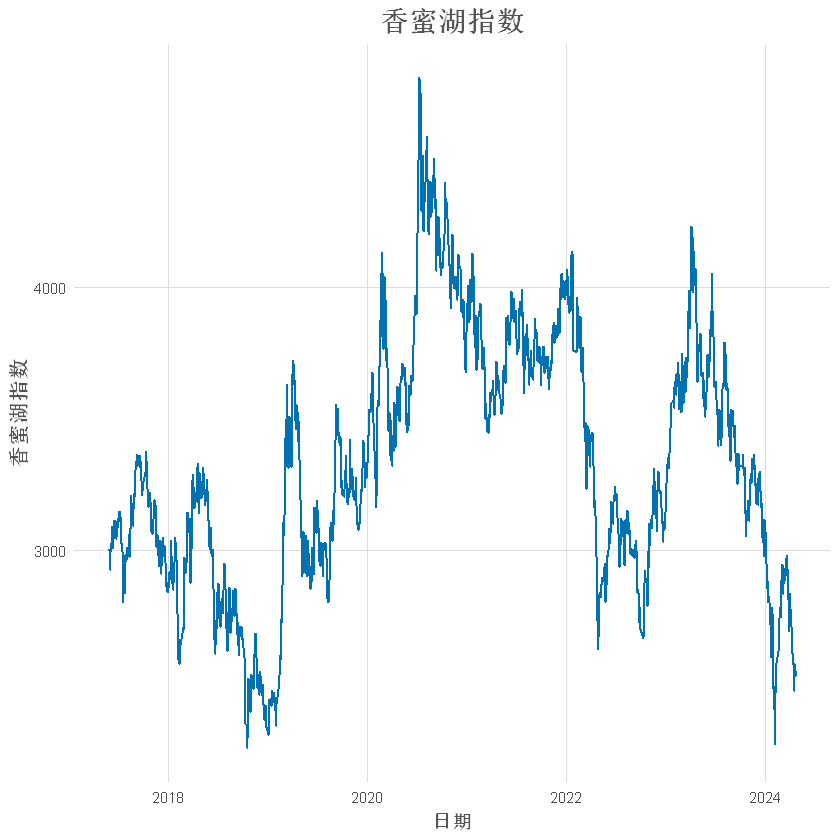

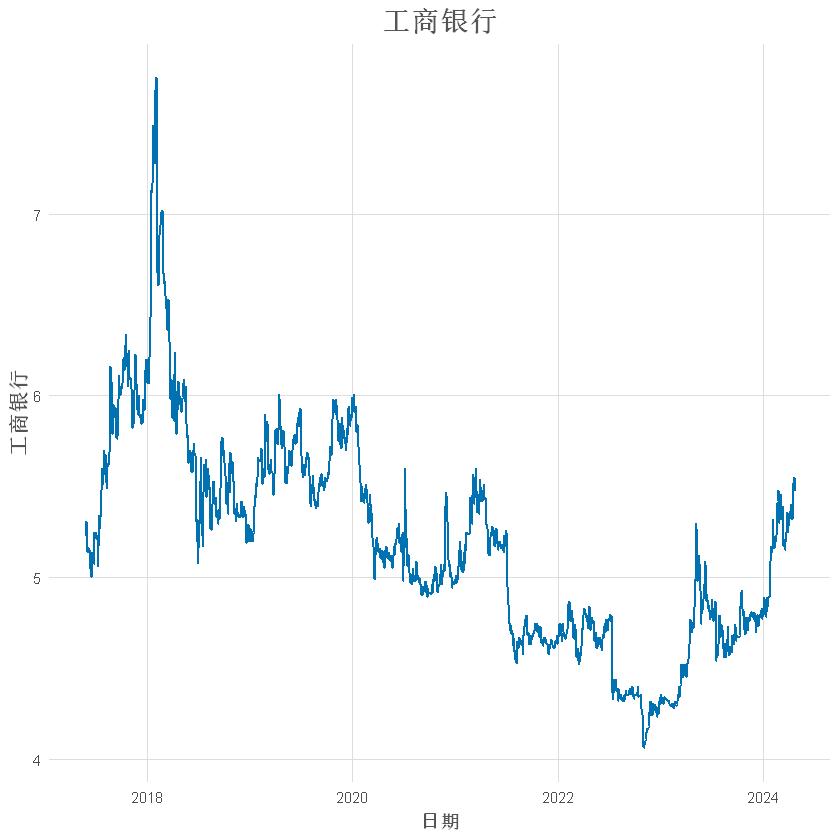

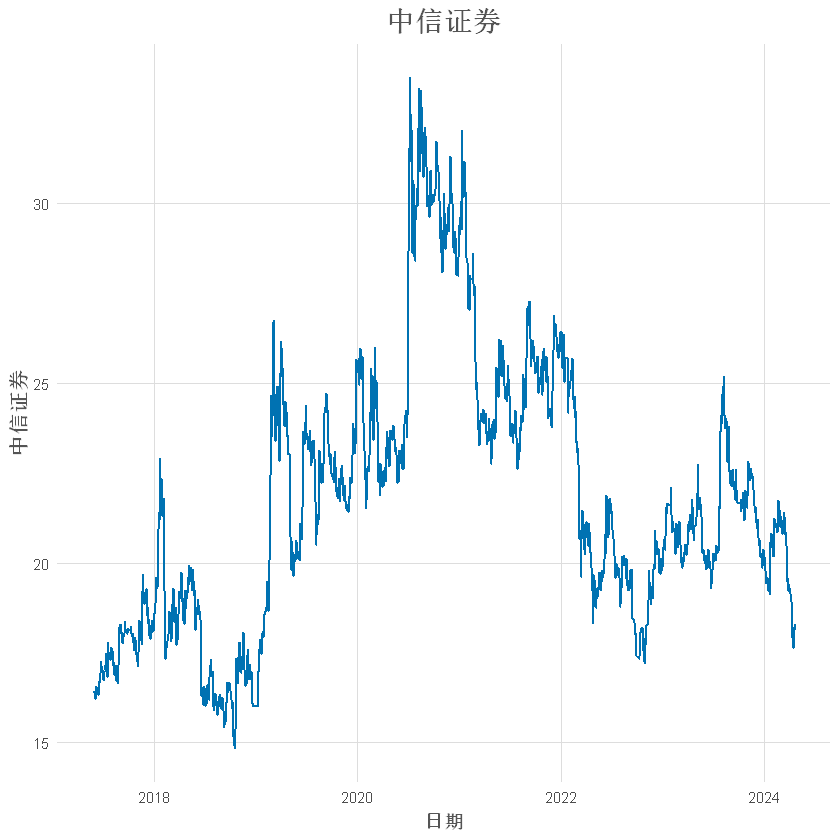

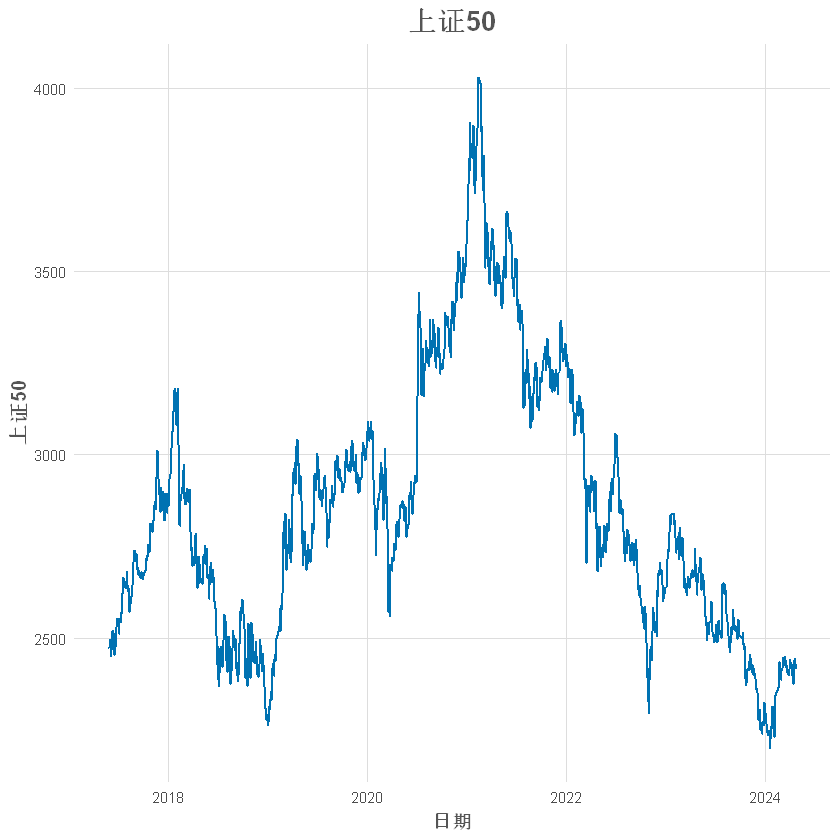

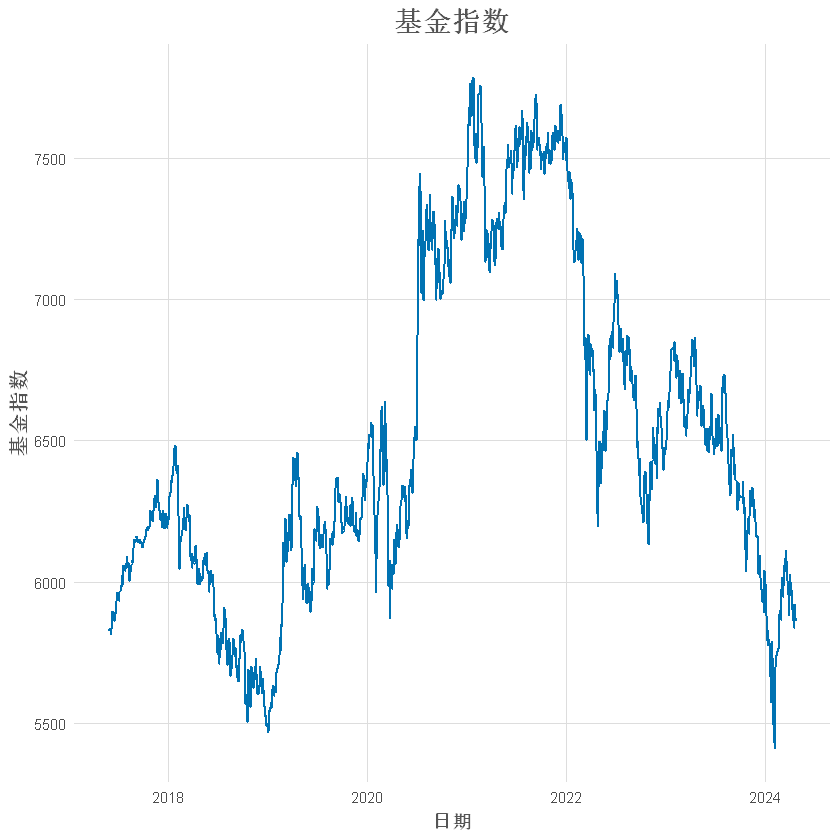

In [3]:

variable_names <- colnames(data)[-which(colnames(data) == "日期")]

for (variable in variable_names) {
  current_data <- data[c("日期", variable)]
  
  p <- ggplot(current_data, aes(x = 日期, y = !!sym(variable))) +
    geom_line(color = "#0072B2", size = 0.8) + 
    labs(
      x = "日期", 
      y = variable, 
      title = paste(variable),
    ) +
    theme_minimal() +
    theme(
      plot.title = element_text(hjust = 0.5, color = "#555555", size = 16, face = "bold"),  # 调整标题样式
      axis.title.x = element_text(face = "bold", color = "#555555", size = 12),
      axis.title.y = element_text(face = "bold", color = "#555555", size = 12),
      panel.grid.major = element_line(color = "#DDDDDD"),
      panel.grid.minor = element_blank(),
      legend.position = "none"
    )
  
  print(p)
}


对数收益率图像

In [4]:
df <- read_excel("./ts_data.xlsx")
df$日期 <- as.Date(df$日期, format = "%Y-%m-%d")
# 调整为日期格式
ts_df <- xts(df[-1], order.by = df$日期)
date_st <- index(ts_df)
dim(ts_df)
tail(ts_df)

[1] 1678    5

           香蜜湖指数   工商银行     基金指数     上证50    中信证券
2024-04-16 -4.0291639  0.9182801 -0.549962451 -0.4838379 -0.62199805
2024-04-17  4.2765524  0.5469476 -0.284285204  1.1351721  2.63099419
2024-04-18 -0.3160644  0.3629768  0.249136693  0.2186259  0.60589555
2024-04-19 -1.6792034  0.5420067  0.098898668 -0.5997007 -0.44028690
2024-04-22  0.3443545 -1.2692827 -0.002398464 -0.2401486  0.82395413
2024-04-23  0.5518959  0.3642991 -0.099072532 -0.4551014 -0.05471956

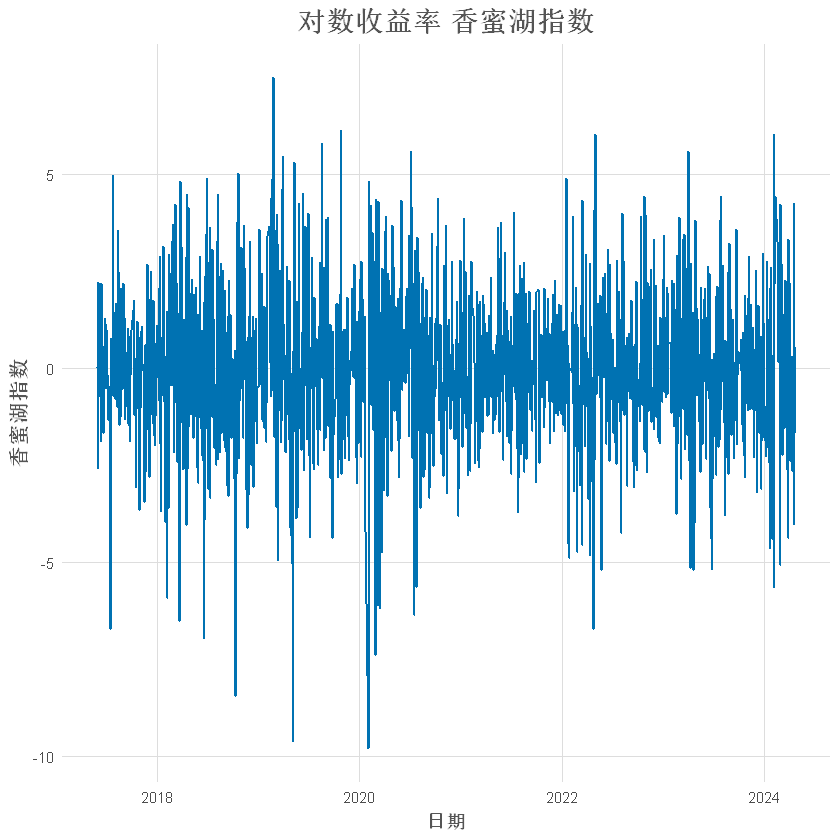

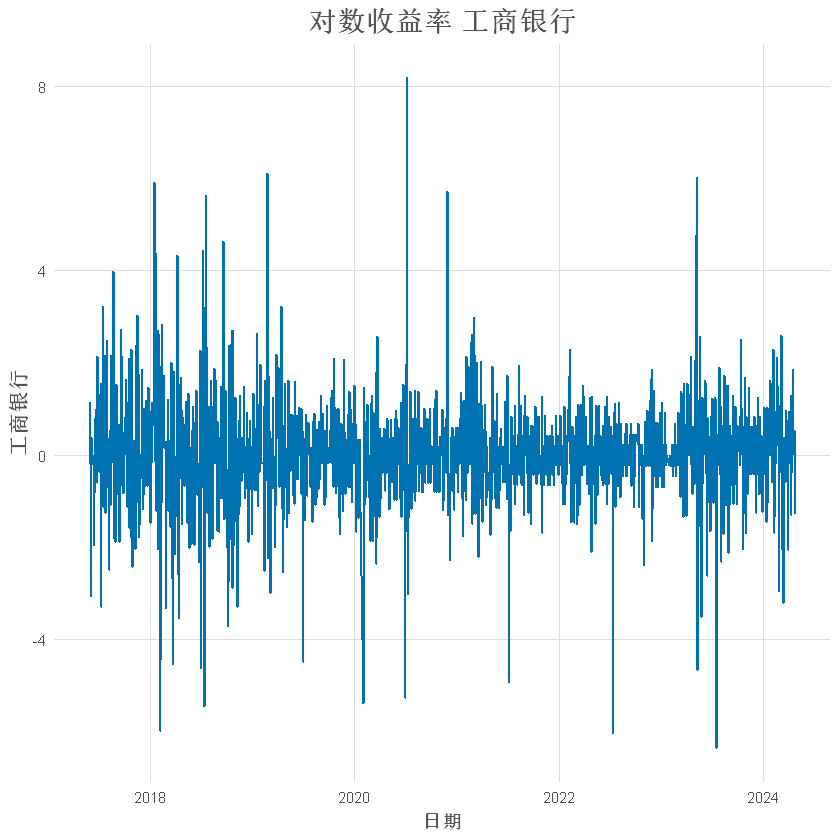

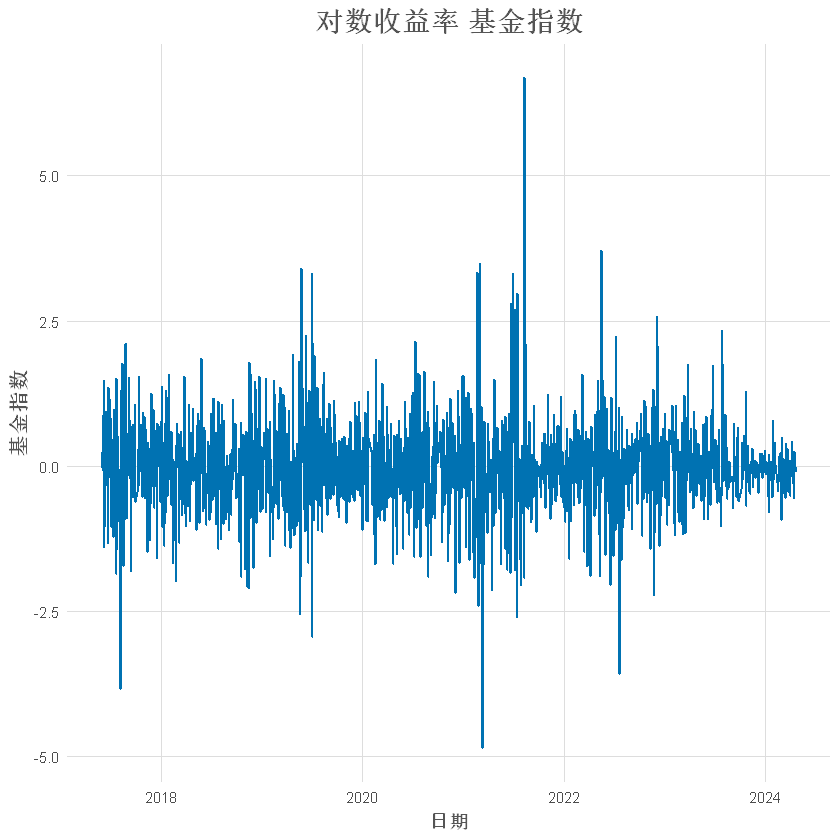

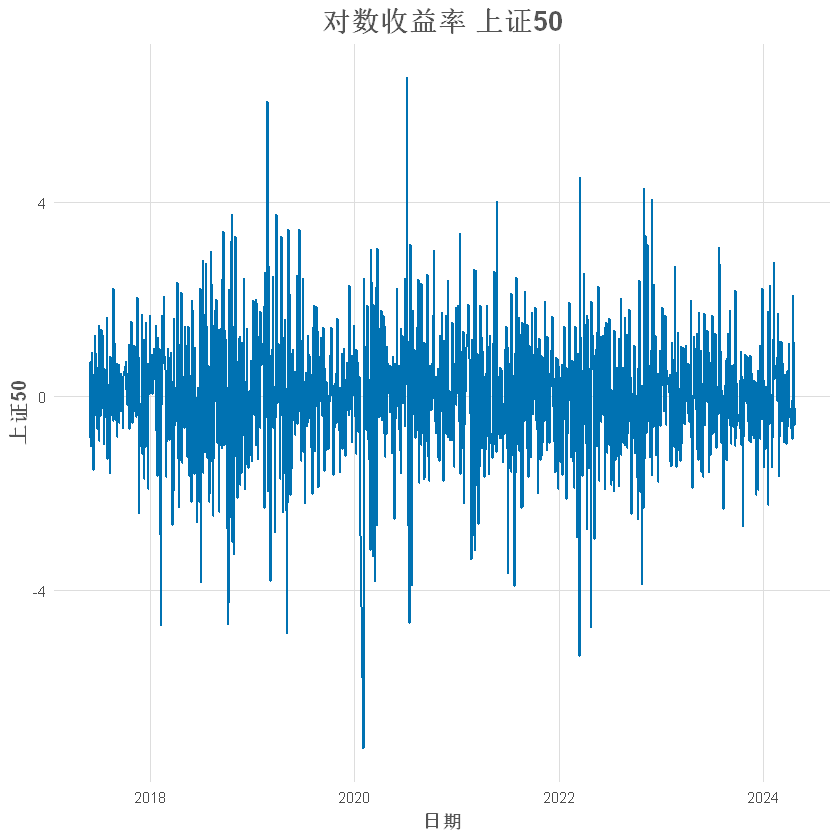

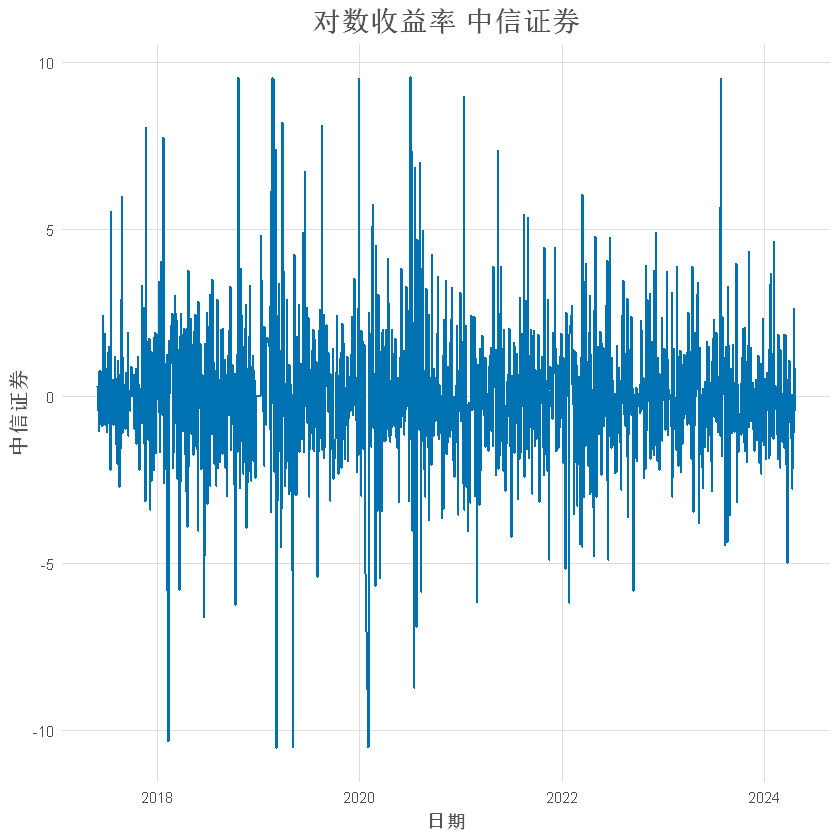

In [5]:
log_data <- colnames(df)[-1]

# 循环遍历每一个变量名
for (variable in log_data) {
  p <- ggplot(df, aes(x = 日期, y = !!sym(variable))) +
    geom_line(color = "#0072B2", size = 0.8) + 
    labs(
      x = "日期", 
      y =  variable, 
      title = paste( '对数收益率',variable)
    ) +
    theme_minimal() +
    theme(
      plot.title = element_text(hjust = 0.5, color = "#555555", size = 16, face = "bold"),
      axis.title.x = element_text(face = "bold", color = "#555555", size = 12),
      axis.title.y = element_text(face = "bold", color = "#555555", size = 12),
      panel.grid.major = element_line(color = "#DDDDDD"),
      panel.grid.minor = element_blank(),
      legend.position = "none"
    )
  
  print(p)
}

描述性统计+ARCH效应检验+JB正态性检验

In [6]:

stats <- data.frame(
  Median = apply(ts_df, 2, median, na.rm = TRUE),
  Max = apply(ts_df, 2, max, na.rm = TRUE),
  Min = apply(ts_df, 2, min, na.rm = TRUE),
  StdDev = apply(ts_df, 2, sd, na.rm = TRUE),
  Skewness = apply(ts_df, 2, skewness, na.rm = TRUE),
  Kurtosis = apply(ts_df, 2, kurtosis, na.rm = TRUE)
)
print(stats)


                 Median      Max        Min    StdDev    Skewness Kurtosis
香蜜湖指数 -0.035582761 7.506944  -9.797493 1.9049984 -0.18531481 4.780378
工商银行    0.000000000 8.183002  -6.358073 1.1494780  0.09004365 9.626870
基金指数    0.009672448 6.686416  -4.857354 0.7849274  0.34936379 8.924402
上证50     -0.002884543 6.583431  -7.261678 1.1993421 -0.12020979 6.028800
中信证券   -0.047676076 9.544971 -10.552661 1.9865896  0.37146930 8.233389


In [7]:

results <- lapply(ts_df, function(column) {
  if (is.numeric(column)) {
    list(
      JarqueBera = jarque.bera.test(column),
      ArchTest = ArchTest(column),
      ADFTest = adf.test(column)
    )
  }
})
print(results)


Warning message in adf.test(column):
"p-value smaller than printed p-value"
Warning message in adf.test(column):
"p-value smaller than printed p-value"
Warning message in adf.test(column):
"p-value smaller than printed p-value"
Warning message in adf.test(column):
"p-value smaller than printed p-value"
Warning message in adf.test(column):
"p-value smaller than printed p-value"


$香蜜湖指数
$香蜜湖指数$JarqueBera

	Jarque Bera Test

data:  column
X-squared = 231.22, df = 2, p-value < 2.2e-16


$香蜜湖指数$ArchTest

	ARCH LM-test; Null hypothesis: no ARCH effects

data:  column
Chi-squared = 57.625, df = 12, p-value = 6.095e-08


$香蜜湖指数$ADFTest

	Augmented Dickey-Fuller Test

data:  column
Dickey-Fuller = -11.395, Lag order = 11, p-value = 0.01
alternative hypothesis: stationary



$工商银行
$工商银行$JarqueBera

	Jarque Bera Test

data:  column
X-squared = 3072.7, df = 2, p-value < 2.2e-16


$工商银行$ArchTest

	ARCH LM-test; Null hypothesis: no ARCH effects

data:  column
Chi-squared = 105.43, df = 12, p-value < 2.2e-16


$工商银行$ADFTest

	Augmented Dickey-Fuller Test

data:  column
Dickey-Fuller = -12.126, Lag order = 11, p-value = 0.01
alternative hypothesis: stationary



$基金指数
$基金指数$JarqueBera

	Jarque Bera Test

data:  column
X-squared = 2488.1, df = 2, p-value < 2.2e-16


$基金指数$ArchTest

	ARCH LM-test; Null hypothesis: no ARCH effects

data:  column
Chi-squared = 71.472, df = 12, p

边缘分布及散点图（初步观察两组数据是有关系的）

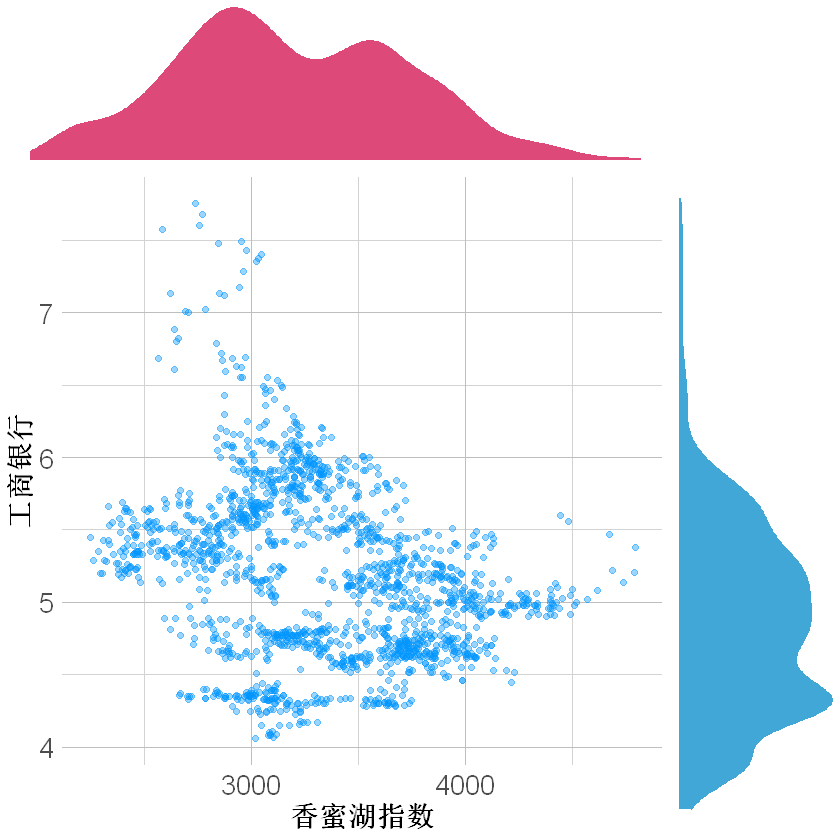

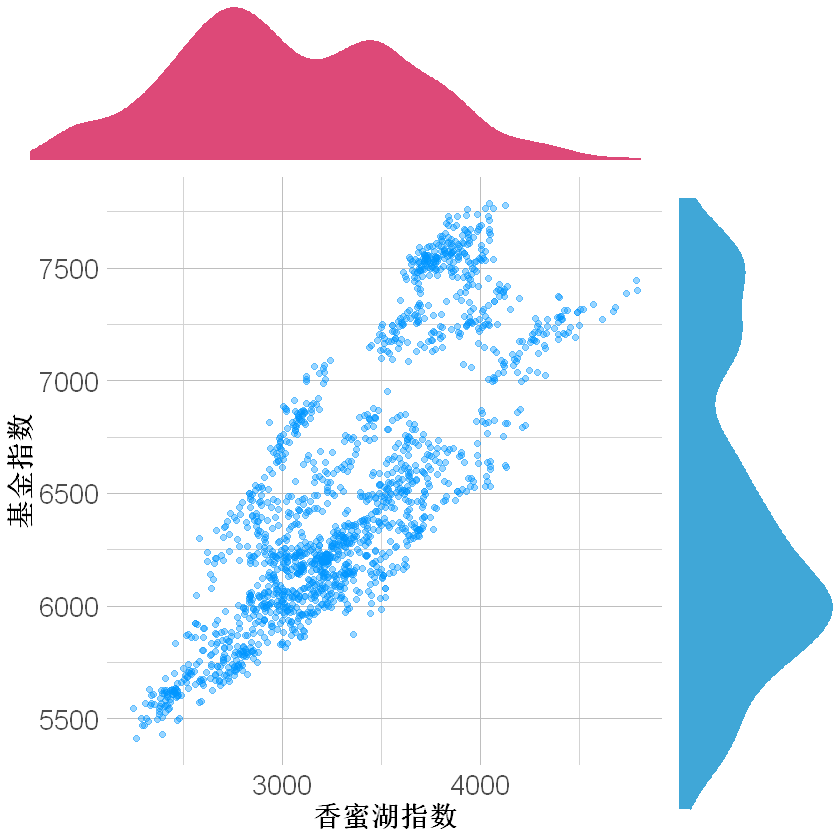

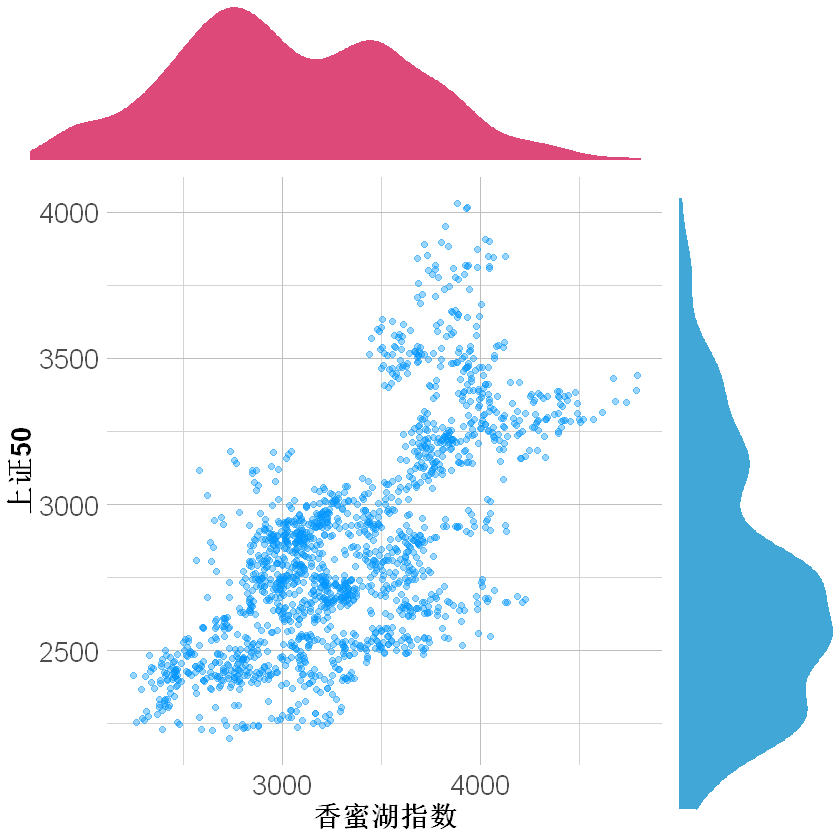

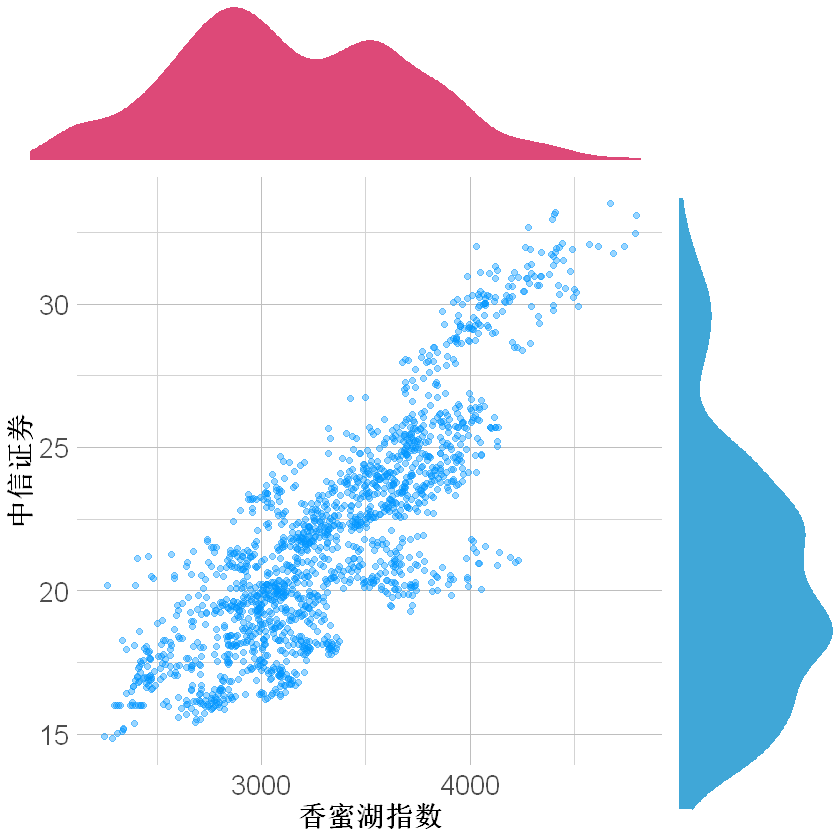

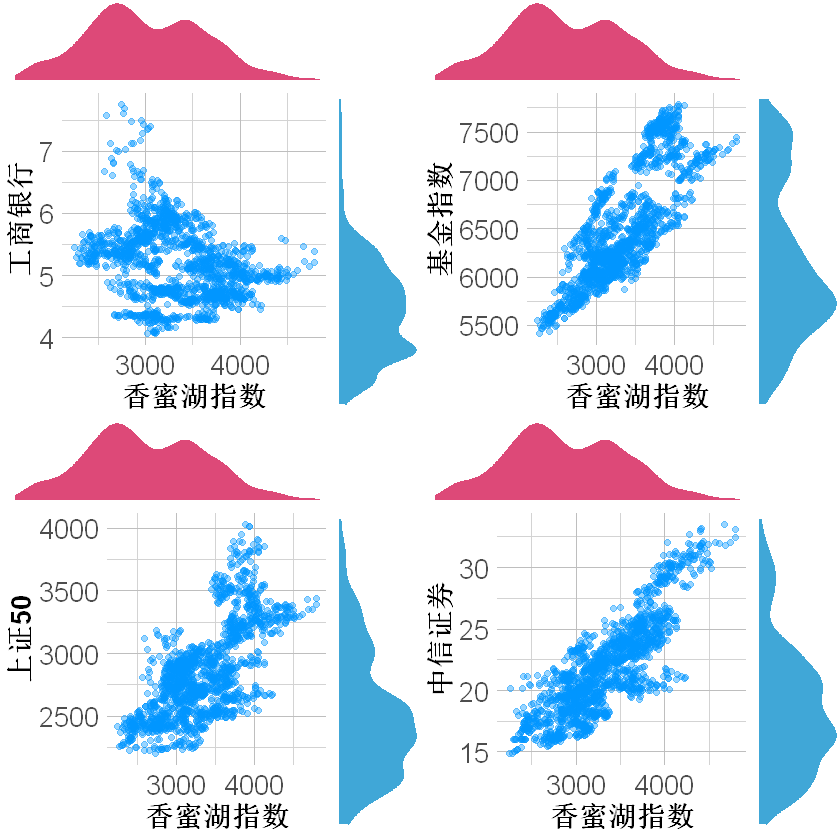

In [8]:
plot_with_marginal_density <- function(data, x_var, y_var) {
  # 使用整洁评估方式处理变量
  x_var_sym <- sym(x_var)
  y_var_sym <- sym(y_var)

  # 主散点图
  main_plot <- ggplot(data, aes(x = !!x_var_sym, y = !!y_var_sym)) +
    geom_point(alpha = 0.4, color = "#0095ff") +
    theme_minimal() +
    theme(panel.grid.major = element_line(color = "gray", linewidth = 0.5),
          panel.grid.minor = element_line(color = "lightgray", linewidth = 0.25),
          text = element_text(size = 16),
          axis.text = element_text(size = 16),
          axis.title = element_text(size = 16, face = "bold"),
          plot.title = element_text(size = 16, hjust = 0.5))

  # X变量的密度图
  top_density <- ggplot(data, aes(x = !!x_var_sym)) +
    geom_density(fill = "#dd4978", color = "#dd4978") +
    theme_void()

  # Y变量的密度图
  right_density <- ggplot(data, aes(x = !!y_var_sym)) +
    geom_density(fill = "#40a7d7", color = "#40a7d7") +
    theme_void() +
    coord_flip()

  # 组合图形
  combined_plot <- grid.arrange(
    top_density, nullGrob(),
    main_plot, right_density,
    ncol = 2, nrow = 2,
    widths = c(4, 1), heights = c(1, 4),
    layout_matrix = matrix(c(1, 2, 3, 4), 2, 2, byrow = TRUE)
  )
  
  return(combined_plot)
}
# 应用函数绘制图形
variables <- c('工商银行', '基金指数', '上证50', '中信证券')
plots <- lapply(variables, function(var) {
  plot_with_marginal_density(data, "香蜜湖指数", var)
})

# 显示图形
do.call(grid.arrange, c(plots, ncol = 2))

对比了不同garch模型和分布的LLF及AIC，确定最终使用ARMA(1，2)-EGARCH(1,1)。此处省略了其他模型结果。

In [9]:
#ARMA(1,2)-egarch(1,1) model（sstd）
uspec <- ugarchspec(mean.model = list(armaOrder = c(1,2), include.mean = TRUE),
variance.model = list(model = "eGARCH", garchOrder = c(1, 1)),
distribution.model = "sstd")
#用刚刚定义的模型拟合各列数据
f1 <- function(x) {ugarchfit(uspec, data = x)}
fit <- apply(ts_df,2, f1)

In [10]:
fit

$香蜜湖指数

*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: eGARCH(1,1)
Mean Model	: ARFIMA(1,0,2)
Distribution	: sstd 

Optimal Parameters
------------------------------------
        Estimate  Std. Error   t value Pr(>|t|)
mu     -0.023863    0.021786   -1.0954 0.273362
ar1    -0.401257    0.054238   -7.3980 0.000000
ma1     0.384819    0.054460    7.0661 0.000000
ma2     0.022553    0.015352    1.4691 0.141815
omega   0.048006    0.004089   11.7400 0.000000
alpha1 -0.039927    0.015853   -2.5185 0.011785
beta1   0.962084    0.000121 7933.6073 0.000000
gamma1  0.145827    0.003527   41.3482 0.000000
skew    1.018494    0.031799   32.0289 0.000000
shape   6.599790    1.070580    6.1647 0.000000

Robust Standard Errors:
        Estimate  Std. Error   t value Pr(>|t|)
mu     -0.023863    0.011293   -2.1131 0.034590
ar1    -0.401257    0.010648  -37.6

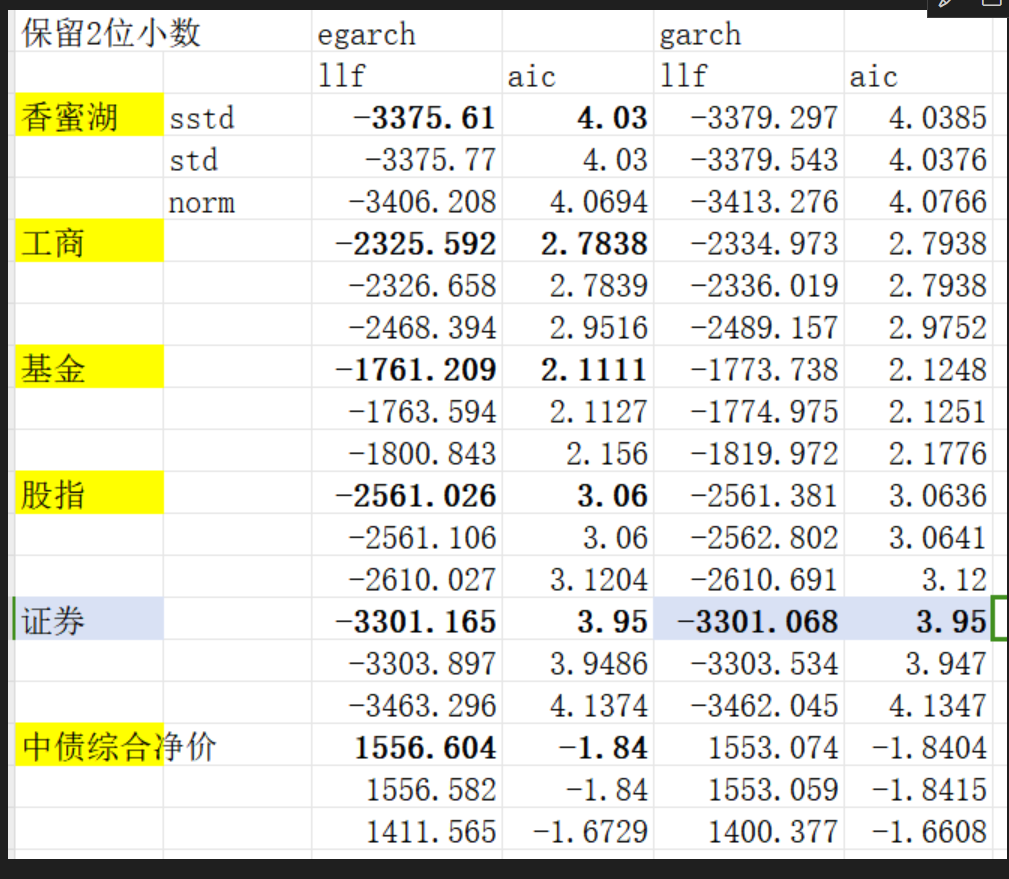

模型拟合结果图像展示

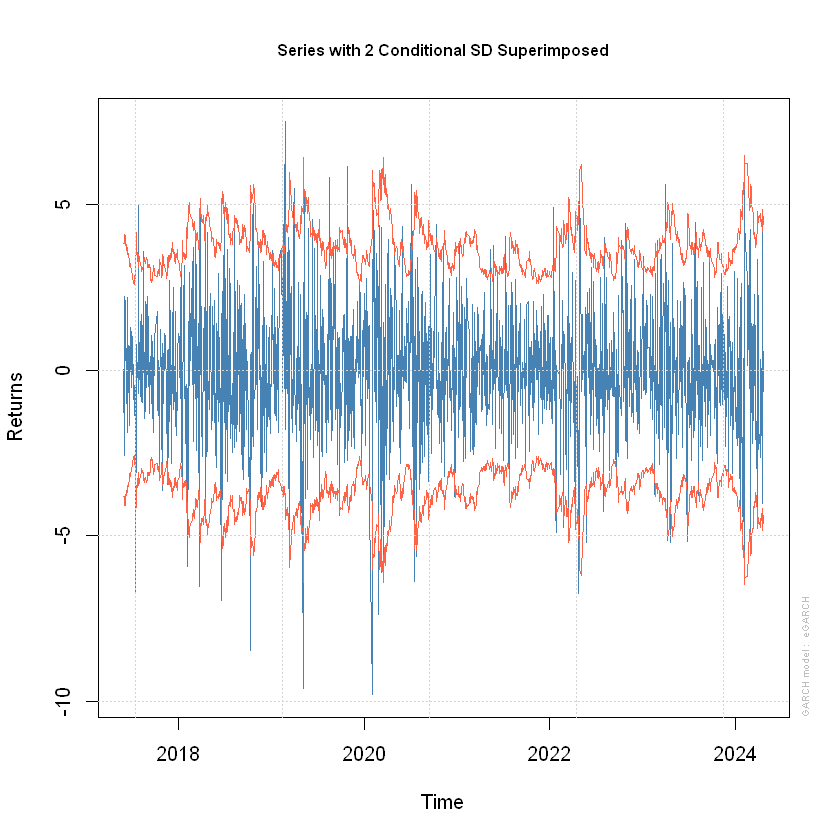

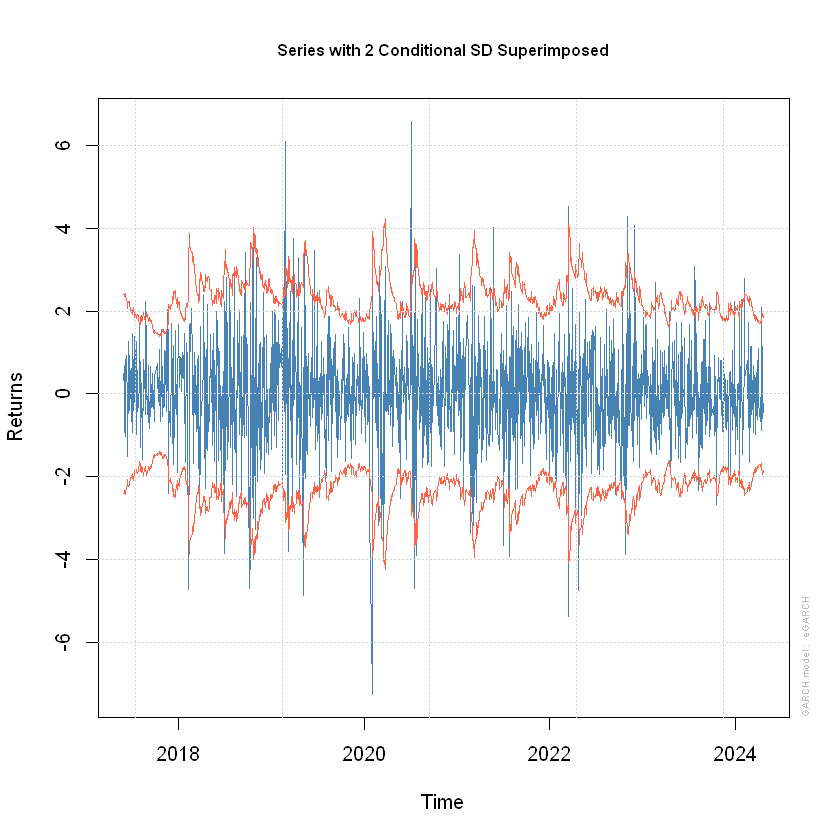

In [11]:
#模型拟合图像(可以都plot一下）)
plot(fit$香蜜湖指数,which=1)
plot(fit$上证50,which=1)

对残差进行进一步处理：一方面检验残差是否为白噪声、是否还存在ARCH效应判断arma-garch模型拟合效果；另一方面针对残差加入evt进一步建模，捕捉极端尾部事件。？

In [12]:
#提取残差
fintech_resi <- residuals(fit$香蜜湖指数)
index(fintech_resi) <- date_st

stock_resi <- residuals(fit$上证50)
index(stock_resi) <- date_st


In [13]:
#香蜜湖指数进一步处理（rrss第一列残差 第二列条件标准差 第三列标准化残差）
spec_fintech <- uspec
setfixed(spec_fintech) <- as.list(coef(fit$香蜜湖指数))
filt_fintech <- ugarchfilter(spec_fintech, ts_df$香蜜湖指数)
rrss <- cbind(fintech_resi,sigma(filt_fintech),fintech_resi/sigma(filt_fintech))
ssss <- cbind(ts_df$香蜜湖指数,fitted(filt_fintech),fintech_resi,sigma(filt_fintech),fintech_resi/sigma(filt_fintech))
#把标准化残差重命名
fintech_res <- fintech_resi/sigma(filt_fintech)

In [14]:
#检验香蜜湖残差是否为白噪声
Box.test(fintech_res,lag = 6, type = "Ljung-Box")
Box.test(fintech_res,lag = 12, type = "Ljung-Box")
Box.test(fintech_res,lag = 20, type = "Ljung-Box")
#残差的ARCH检验
ArchTest(fintech_res, lags = 6)
ArchTest(fintech_res, lags = 12)
ArchTest(fintech_res, lags = 20)


	Box-Ljung test

data:  fintech_res
X-squared = 6.9773, df = 6, p-value = 0.323



	Box-Ljung test

data:  fintech_res
X-squared = 10.187, df = 12, p-value = 0.5995



	Box-Ljung test

data:  fintech_res
X-squared = 19.46, df = 20, p-value = 0.4921



	ARCH LM-test; Null hypothesis: no ARCH effects

data:  fintech_res
Chi-squared = 1.759, df = 6, p-value = 0.9405



	ARCH LM-test; Null hypothesis: no ARCH effects

data:  fintech_res
Chi-squared = 7.6409, df = 12, p-value = 0.8125



	ARCH LM-test; Null hypothesis: no ARCH effects

data:  fintech_res
Chi-squared = 8.4645, df = 20, p-value = 0.9883


In [15]:
#股票进一步处理（rrss3第一列残差 第二列条件标准差 第三列标准化残差）
spec_stock <- uspec
setfixed(spec_stock) <- as.list(coef(fit$上证50))
filt_stock <- ugarchfilter(spec_stock, ts_df$上证50)
rrss3 <- cbind(stock_resi,sigma(filt_stock),stock_resi/sigma(filt_stock))
ssss3 <- cbind(ts_df$上证50,fitted(filt_stock),stock_resi,sigma(filt_stock),stock_resi/sigma(filt_stock))
#把标准化残差重命名
stock_res <- stock_resi/sigma(filt_stock)

In [16]:
Box.test(stock_res,lag = 6, type = "Ljung-Box")
Box.test(stock_res,lag = 12, type = "Ljung-Box")
Box.test(stock_res,lag = 20, type = "Ljung-Box")

ArchTest(stock_res, lags = 6)
ArchTest(stock_res, lags = 12)
ArchTest(stock_res, lags = 20)


	Box-Ljung test

data:  stock_res
X-squared = 12.42, df = 6, p-value = 0.05322



	Box-Ljung test

data:  stock_res
X-squared = 15.658, df = 12, p-value = 0.2074



	Box-Ljung test

data:  stock_res
X-squared = 22.342, df = 20, p-value = 0.3223



	ARCH LM-test; Null hypothesis: no ARCH effects

data:  stock_res
Chi-squared = 7.8169, df = 6, p-value = 0.2518



	ARCH LM-test; Null hypothesis: no ARCH effects

data:  stock_res
Chi-squared = 13.021, df = 12, p-value = 0.3675



	ARCH LM-test; Null hypothesis: no ARCH effects

data:  stock_res
Chi-squared = 17.153, df = 20, p-value = 0.643


Fitted composite GPD-Normal-GPD distribution: 

Breakpoints: -1.884652 1.600083 
Weights: 0.030989 0.918355 0.050656 

Parameters: 
     loc1    scale1    shape1      mean        sd      loc2    scale2    shape2 
 1.884652  0.731745 -0.038165  0.002507  0.871389  1.600083  0.615448 -0.146771 

Log-likelihood: -2338.975,  Average log-likelihood: -1.3939


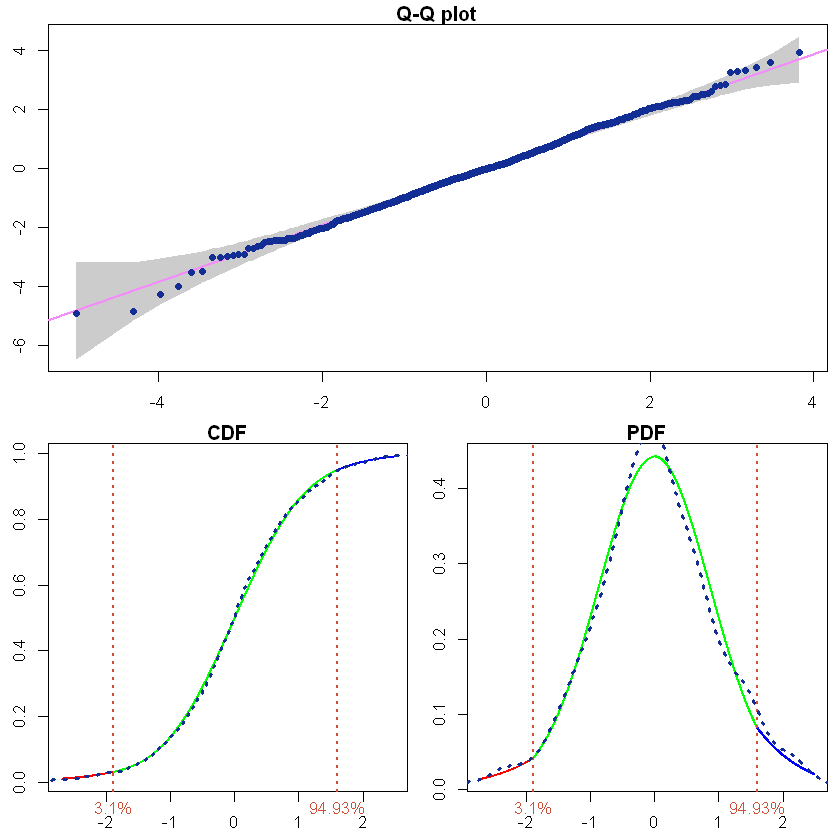

In [17]:
evt_fintech<-GNG_fit(fintech_res, start = c(break1 = -2, break2 =1.5, mean = 0, sd =1,shape1 = 0.1, shape2= 0.1))
evt_fintech
plot(evt_fintech)

由图像可以看出加入evt后模型得到一定修正，实际数据分布和理论分布相似度高。再结合LLF值（这个LLF和上面ARMA-GARCH建模结果的LLF值有对比的意义吗？）

关于evt什么时候可以用，随便看了一个知网论文，里面就是大概说了一下收益数据厚尾，所以就直接用evt了 放了一下evt的参数。所以我觉得是不是直接用就行？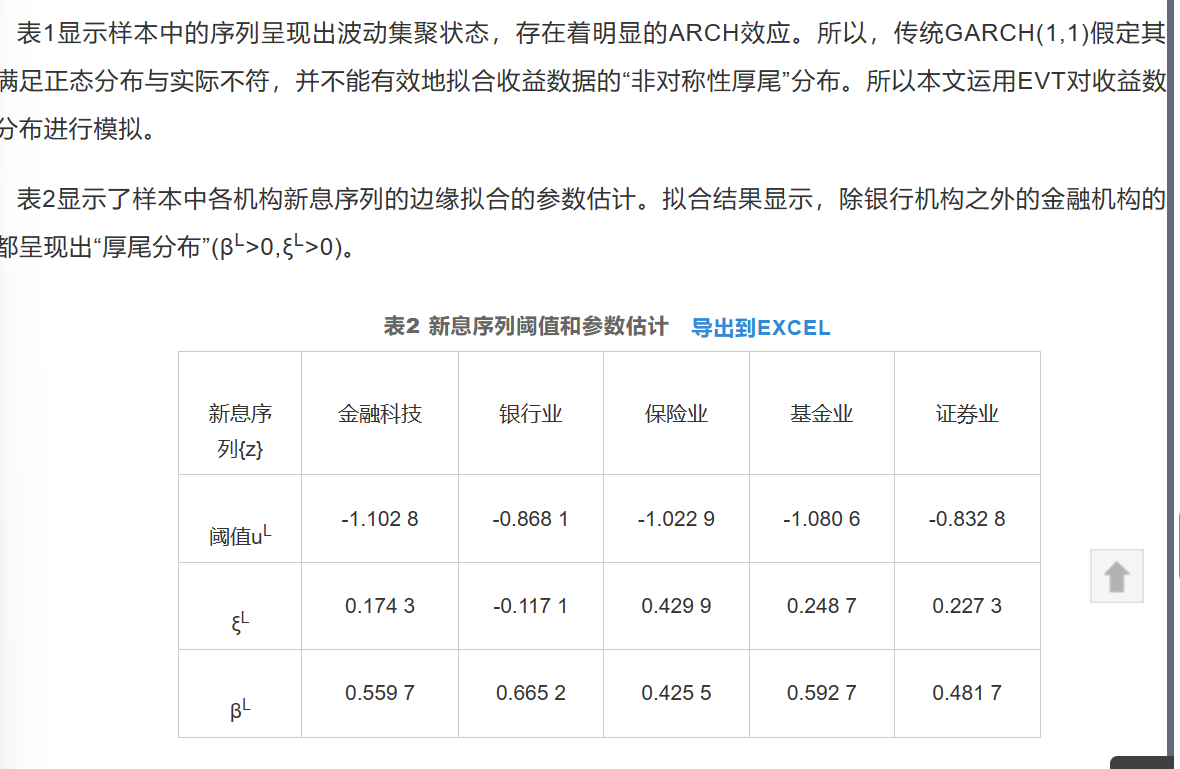

In [18]:
#下尾形状参数0.081，尺度参数0.6373；上尾形状参数0.0527，尺度参数：0.6502 下阈值-1.8116,上阈值1.7795
distribution(evt_fintech)

Composite distribution with: 
 
  Trafo       Distribution                                    Parameters Weight
1  -X   Generalized Pareto loc = 1.8847, scale = 0.7317, shape = -0.0382 0.0310
2 none        Normal                mean = 0.0025, sd = 0.8714           0.9184
3 none  Generalized Pareto loc = 1.6001, scale = 0.6154, shape = -0.1468 0.0507
        Truncation
1  (-Inf,-1.8847) 
2 [-1.8847,1.6001)
3   [1.6001,Inf)  

Fitted composite GPD-Normal-GPD distribution: 

Breakpoints: -1.951022 1.333546 
Weights: 0.026818 0.896901 0.076281 

Parameters: 
     loc1    scale1    shape1      mean        sd      loc2    scale2    shape2 
 1.951022  0.829992 -0.055222 -0.023144  0.837895  1.333546  0.620580  0.001488 

Log-likelihood: -2313.414,  Average log-likelihood: -1.3787


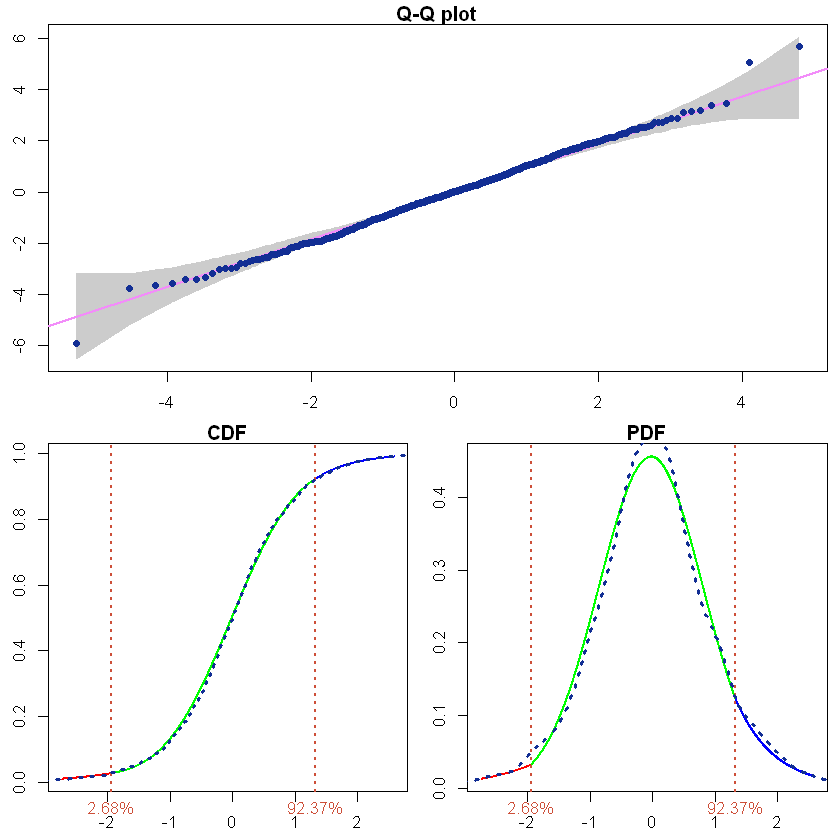

In [19]:
evt_stock <- GNG_fit(stock_res, start = c(break1 = -2, break2 =1.5, mean = 0, sd =1,shape1 = 0.1, shape2= 0.1))
evt_stock
plot(evt_stock)

In [20]:
# 下尾形状参数-0.0552尺度参数0.83，上尾形状参数0.0015尺度参数0.6206
distribution(evt_stock)

Composite distribution with: 
 
  Trafo       Distribution                                   Parameters Weight
1  -X   Generalized Pareto  loc = 1.951, scale = 0.83, shape = -0.0552  0.0268
2 none        Normal               mean = -0.0231, sd = 0.8379          0.8969
3 none  Generalized Pareto loc = 1.3335, scale = 0.6206, shape = 0.0015 0.0763
       Truncation
1  (-Inf,-1.951) 
2 [-1.951,1.3335)
3  [1.3335,Inf)  

In [24]:
data_res <- cbind(fintech_res, stock_res)
# write.csv(data_res, "./residuals_1.csv")
ts_df_1 <- read.csv("./residuals_1.csv")

In [25]:
dim(ts_df_1)
tail(ts_df_1)
tail(data_res)

[1] 1678    3

,X,fintech_res,stock_res
,<int>,<dbl>,<dbl>
1673,1673,-1.88005276,-0.5264179
1674,1674,1.78924427,1.2481220
1675,1675,-0.04012605,0.1729186
1676,1676,-0.80141927,-0.5671140
1677,1677,0.17766124,-0.2994014
1678,1678,0.27698175,-0.4611304


           fintech_res  stock_res
2024-04-16 -1.88003026 -0.5263944
2024-04-17  1.78934668  1.2480997
2024-04-18 -0.04024894  0.1729207
2024-04-19 -0.80137688 -0.5671008
2024-04-22  0.17758015 -0.2994012
2024-04-23  0.27700990 -0.4611286

In [26]:
o <- order(ts_df_1$fintech_res)
rd1 <- cbind(ts_df_1$fintech_res[o],ts_df_1$stock_res[o])
x <- rd1[, 1]
y1 <- rd1[, 2]
#香蜜湖&股票
Dat1 <- NULL
Dat1$x <- x
Dat1$y <- y1

常用的copula集合，上尾下尾分别用不同的copula建模，优化过程用内点法（？，保持初值一定的情况下对比LLF的值，选出最优的copula。

其实这里copula也有一些疑问就是copula本身不是有很多吗?看到其他论文里也用了很多别的二元copula，这点是需要怎么说明一下吗？还是说默认就选几种然后挑个结果好的就行？（不过共同点就是都需要针对不同市场选出最好的copula。。这个就又回到了细分的金融子市场里变量不能太多，所以需要加一种方法找到能代表某个市场的指标之类的才好操作...)或者也有选择一个市场研究的，比如银行就只研究多家银行，建立一个矩阵 不过我觉得这个好像没有前一个可说的多 担心分量问题。
这个是多个市场的
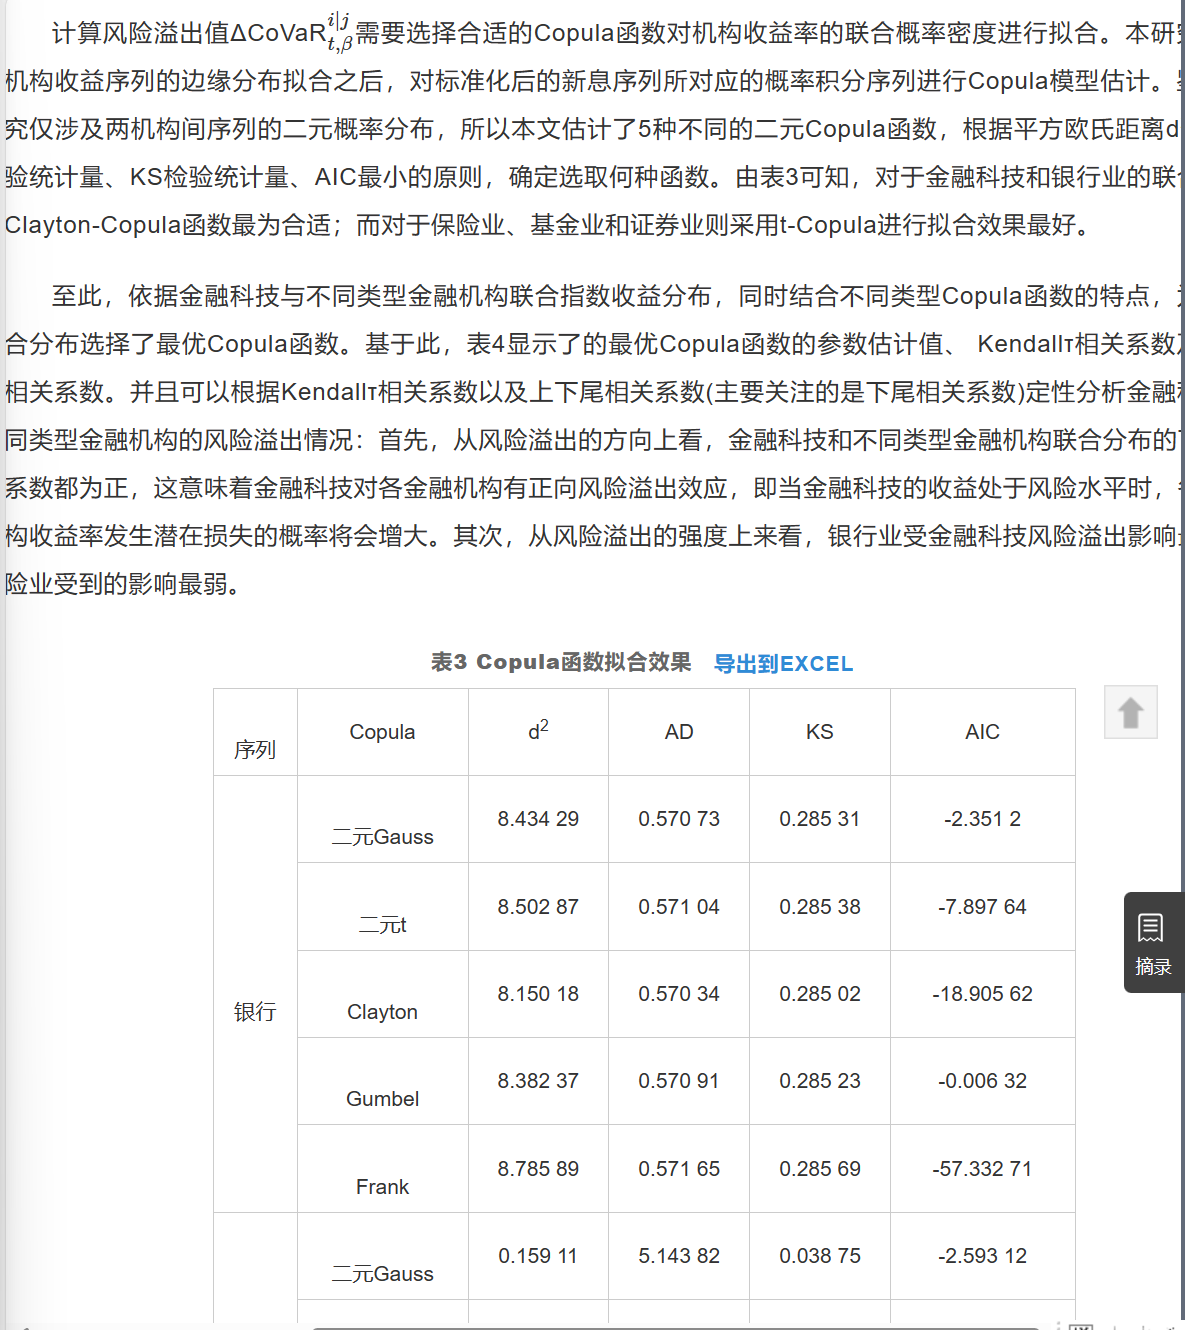
并且这个里面没有仔细说evt是怎么和garch联系在一起的，也是对残差序列进一步建模得到边缘分布吗？（为什么是对残差进行evt建模这点有点不太理解 那之后建立copula时用的边缘分布就是用evt建模残差的分布吗 感觉有点奇怪...

In [27]:
#copula集合
# √ Clayton copula
conditional_clayton_copula <- function(u, v, delta) {
  (1 + u^delta * (v^(-delta) - 1))^(-1 / delta - 1)
}

# √ Rotated Clayton copula
conditional_rotated_clayton_copula <- function(u, v, delta) {
  1 - (1 + (1 - u)^delta * ((1 - v)^(-delta) - 1))^(-1 / delta - 1)
}

# √ Joe copula
conditional_joe_copula <- function(u, v, delta) {
  term1 <- 1 + (1 - u)^(-delta) * (1 - v)^delta - (1 - v)^delta
  term2 <- (1 - (1 - v)^delta)
  result <- (term1)^((1 - delta) / delta) * term2
  return(result)
}


# √ Rotated Joe copula
conditional_rotated_joe_copula <- function(u, v, delta) {
  term1 <- 1 + u^(-delta) * v^delta - v^delta
  term2 <- (1 - v^delta)
  result <- 1 - (term1)^((1 - delta) / delta) * term2
  return(result)
}

#test gumbel copula
# Gumbel copula
gumbel_copula <- function(u, v, delta) {
  exp(-((-log(u))^delta + (-log(v))^delta)^(1/delta))
}

# Gumbel copula conditional distribution function
conditional_gumbel_copula <- function(u, v, delta) {
  term1 <- u^(-1)
  term2 <- gumbel_copula(u, v, delta)
  term3 <- (1 + (log(v) / log(u))^delta)^((1 - delta) / delta)
  result <- term1 * term2 * term3
  return(result)
}

# Rotated Gumbel copula
rotated_gumbel_copula <- function(u, v, delta) {
  u + v - 1 + gumbel_copula(1 - u, 1 - v, delta)
}

# Rotated Gumbel copula conditional distribution function
conditional_rotated_gumbel_copula <- function(u, v, delta) {
  term1 <- (1 - u)^(-1)
  term2 <- gumbel_copula(1 - u, 1 - v, delta)
  term3 <- (1 + (log(1 - v) / log(1 - u))^delta)^((1 - delta) / delta)
  result <- 1 - term1 * term2 * term3
  return(result)
}

# Galambos copula
galambos_copula <- function(u, v, delta) {
  u * v * exp(-(((-log(u))^(-delta) + (-log(v))^(-delta))^(-1/delta)))
}

# Galambos copula conditional distribution function
conditional_galambos_copula <- function(u, v, delta) {
  term1 <- u^(-1)
  term2 <- galambos_copula(u, v, delta)
  term3 <- 1 - (1 + (log(u) / log(v))^delta)^(-(1 + delta) / delta)
  result <- term1 * term2 * term3
  return(result)
}

# Galambos copula
galambos_copula <- function(u, v, delta) {
  u * v * exp(-(((-log(u))^(-delta) + (-log(v))^(-delta))^(-1/delta)))
}

# Rotated Galambos copula
rotated_galambos_copula <- function(u, v, delta) {
  u + v - 1 + galambos_copula(1 - u, 1 - v, delta)
}

# Rotated Galambos copula conditional distribution function
conditional_rotated_galambos_copula <- function(u, v, delta) {
  term1 <- (1 - u)^(-1)
  term2 <- galambos_copula(1 - u, 1 - v, delta)
  term3 <- 1 - (1 + (log(1 - u) / log(1 - v))^delta)^(-(1 + delta) / delta)
  result <- 1 - term1 * term2 * term3
  return(result)
}


# Load the necessary package for the phi function
library(stats)

# Hüsler-Reiss copula
husler_reiss_copula <- function(u, v, delta) {
  phi_u <- pnorm(delta^-1 + 0.5 * delta * log(log(u) / log(v)))
  phi_v <- pnorm(delta^-1 + 0.5 * delta * log(log(v) / log(u)))
  result <- exp(phi_u * log(u) + phi_v * log(v))
  return(result)
}

# Hüsler-Reiss copula conditional distribution function
conditional_husler_reiss_copula <- function(u, v, delta) {
  phi_u <- pnorm(delta^-1 + 0.5 * delta * log(log(u) / log(v)))
  copula_value <- husler_reiss_copula(u, v, delta)
  result <- copula_value * u^-1 * phi_u
  return(result)
}

# Rotated Hüsler-Reiss copula
rotated_husler_reiss_copula <- function(u, v, delta) {
  u + v - 1 + husler_reiss_copula(1 - u, 1 - v, delta)
}

# Rotated Hüsler-Reiss copula conditional distribution function
conditional_rotated_husler_reiss_copula <- function(u, v, delta) {
  phi <- pnorm(delta^-1 + 0.5 * delta * log(log(1 - u) / log(1 - v)))
  copula_value <- husler_reiss_copula(1 - u, 1 - v, delta)
  result <- 1 - copula_value * (1 - u)^-1 * phi
  return(result)
}

In [28]:
#香蜜湖
u <- p(distribution(evt_fintech),x)

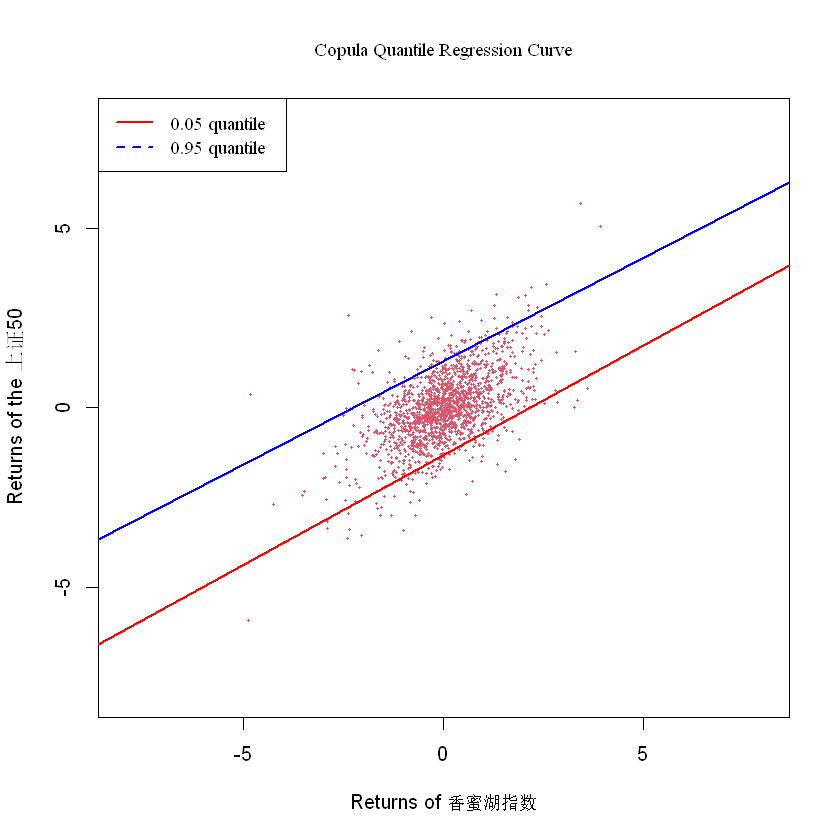

In [29]:
rq05 <- rq(y1 ~ x, tau = 0.05, data = Dat1)  # 0.05分位数回归
rq95 <- rq(y1 ~ x, tau = 0.95, data = Dat1)  # 0.95分位数回归
# 绘制基础图形
plot(x, y1, col = 2, cex = 0.5, pch = 20, xlim = c(-8, 8), ylim = c(-8, 8),
     main = 'Copula Quantile Regression Curve', font.main = 6, cex.main = 0.95,
     xlab = 'Returns of 香蜜湖指数', ylab = 'Returns of the 上证50')

# 添加分位数回归线
abline(rq05, col = "red", lwd = 2)  # 0.05分位数线
abline(rq95, col = "blue", lwd = 2)  # 0.95分位数线

# 添加图例
legend('topleft', c("0.05 quantile", "0.95 quantile"), col = c("red", "blue"),   
       lty = c(1, 2), lwd = c(2, 2), cex = 0.95, text.font = 6)

copula的对比：Gumbel copula

In [30]:
# 初始化deltas矩阵(gumbel copula)
if(!exists("deltas") || !is.matrix(deltas)) {
    deltas <- matrix(NA, nrow = 10, ncol = 3)  # 调整行数和列数
}
#
GumbelModel <- function(x, alpha, mu, sigma, tau)
{
v <- matrix(0, length(u), 1)
u <- p(distribution(evt_fintech),x)
for(i in 1 :length(u))
{
rootf1 <- function(v){1 - exp(-((-log(1 - u[i]))^alpha + (-log(1 - v))^alpha)^(1/alpha)) * 
    (((-log(1 - u[i]))^alpha + (-log(1 - v))^alpha)^((1/alpha) - 
     1) * ((1/alpha) * ((-log(1 - u[i]))^(alpha - 1) * (alpha * 
    (1/(1 - u[i]))))))-tau}
vx <- uniroot(rootf1, c(0.00000000001, 0.999999999999))
v[i,1] <- vx$root
}
z <- mistr_q(distribution(evt_stock), v)
mu + sigma * z
}
##mu is the panning parameter and sigma is the zooming parameter 

156.1351 :   1.1257506 -0.1261274  1.0103893 
final  value 148.375064 
converged
lambda = 0.2294573 
148.3751 :   1.18624104 -0.01342359  0.89458179 
final  value 148.375064 
converged
lambda = 0 
148.3751 :   1.18624104 -0.01342359  0.89458179 



Call: nlrq(formula = y1 ~ GumbelModel(x, delta, mu, sigma, tau), data = Dat1, 
    start = list(delta = 1.1257506, mu = -0.1261274, sigma = 1.0103893), 
    tau = tau, trace = TRUE, control = list(maxiter = 100, k = 2, 
        InitialStepSize = 1, big = 1e+20, eps = 1e-07, beta = 0.97))

tau: [1] 0.05

Coefficients:
      Value    Std. Error t value  Pr(>|t|)
delta  1.18624  0.13553    8.75238  0.00000
mu    -0.01342  0.46353   -0.02896  0.97690
sigma  0.89458  0.26409    3.38740  0.00072

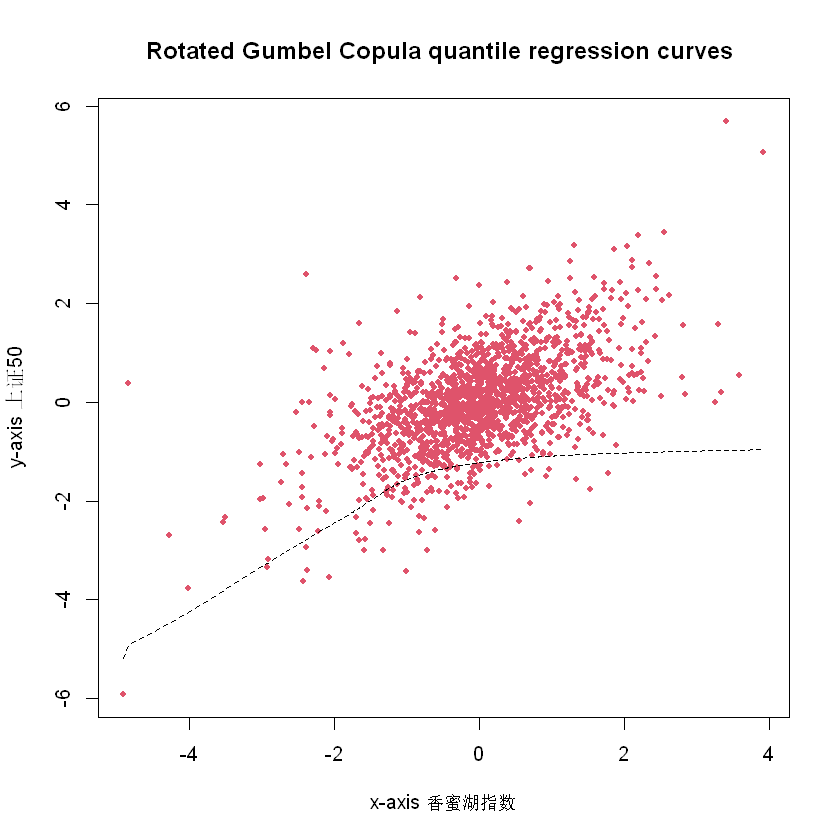

In [31]:
tau = 0.05
fit3 <- nlrq(y1 ~ GumbelModel(x, delta,mu, sigma, tau),
data=Dat1, tau=tau, start = list(delta=1.1257506, mu=-0.1261274, sigma=1.0103893), trace=TRUE)
plot(x, y1, main="Rotated Gumbel Copula quantile regression curves ", xlab="x-axis 香蜜湖指数", ylab="y-axis 上证50", type='p',col = 2, pch=20)
lines(x, predict(fit3, newdata = x), lty = 2, lwd = 1, col = 1)
deltas[3,] <- coef(fit3)
summary(fit3)

In [90]:
## 输出尾部相关系数
delta <- as.numeric(coef(fit3)[1])
fitted_gumbel <- huslerReissCopula(delta)
rot_copula <- rotCopula(fitted_gumbel)
lambda(rot_copula)

lower    upper 
0.399229 0.000000

In [55]:
#输出各个copula LLF AIC BIC数值的函数
  # 假设残差服从正态分布，使用dnorm函数计算对数似然值？
  #（arma-egarch-evt建模后的残差是不是只能默认正态白噪声
log_likelihood <- function(model, data, tau) {
  residuals <- residuals(model)
  n <- length(residuals)
  
  llf <- sum(dnorm(residuals, mean = 0, sd = sd(residuals), log = TRUE))
  
  return(llf)
}

# 计算AIC和BIC
calculate_aic_bic <- function(model, data, tau) {
  llf <- log_likelihood(model, data, tau)
  k <- length(coef(model))  # 模型参数个数
  n <- nrow(as.data.frame(data))           # 样本量
  
  aic <- -2 * llf + 2 * k
  bic <- -2 * llf + log(n) * k
  
  return(list(AIC = aic, BIC = bic, LLF = llf))
}


In [56]:
# rotated gumabel 评价
results <- calculate_aic_bic(fit3, Dat1, 0.05)

cat("LLF:", results$LLF, "\n")
cat("AIC:", results$AIC, "\n")
cat("BIC:", results$BIC, "\n")

LLF: -4117.432 
AIC: 8240.863 
BIC: 8257.14 


In [57]:
#Gumbel copula quantile regression model
u <- p(distribution(evt_fintech),x)
uGumbelModel <- function(x, delta, mu, sigma, tau)
{
v <- matrix(0, length(u), 1)
u <- p(distribution(evt_fintech),x)
for(i in 1 :length(u))
{
rootf1 <- function(v){exp(-((-log(u[i]))^delta + (-log(v))^delta)^(1/delta)) * (((-log(u[i]))^delta + 
   (-log(v))^delta)^((1/delta) - 1) * ((1/delta) * ((-log(u[i]))^(delta - 1) * (delta * (1/u[i])))))-tau}
vx <- uniroot(rootf1, c(0.000000001, 0.9999999999))
v[i,1] <- vx$root
}
z <- mistr_q(distribution(evt_stock),v)
mu + sigma * z
}

151.8887 :   1.1257506 -0.1261274  1.0103893 
final  value 151.368634 
converged
lambda = 0.05783917 
151.3686 :   1.1412929 -0.1411622  0.9832914 
final  value 145.198520 
converged
lambda = 0.9320254 
145.1985 :   1.2206869 -0.7685485  1.3676717 
final  value 143.811866 
converged
lambda = 1 
143.8119 :   1.2990465 -0.5159215  1.2787981 
final  value 143.736094 
converged
lambda = 0.372438 
143.7361 :   1.2837807 -0.5099356  1.2847258 
final  value 143.736094 
converged
lambda = 0 
143.7361 :   1.2837807 -0.5099356  1.2847258 



Call: nlrq(formula = y1 ~ uGumbelModel(x, delta, mu, sigma, tau), data = Dat1, 
    start = list(delta = 1.1257506, mu = -0.1261274, sigma = 1.0103893), 
    tau = tau, trace = TRUE, control = list(maxiter = 100, k = 2, 
        InitialStepSize = 1, big = 1e+20, eps = 1e-07, beta = 0.97))

tau: [1] 0.95

Coefficients:
      Value    Std. Error t value  Pr(>|t|)
delta  1.28378  0.18866    6.80477  0.00000
mu    -0.50994  0.69127   -0.73768  0.46081
sigma  1.28473  0.38057    3.37580  0.00075

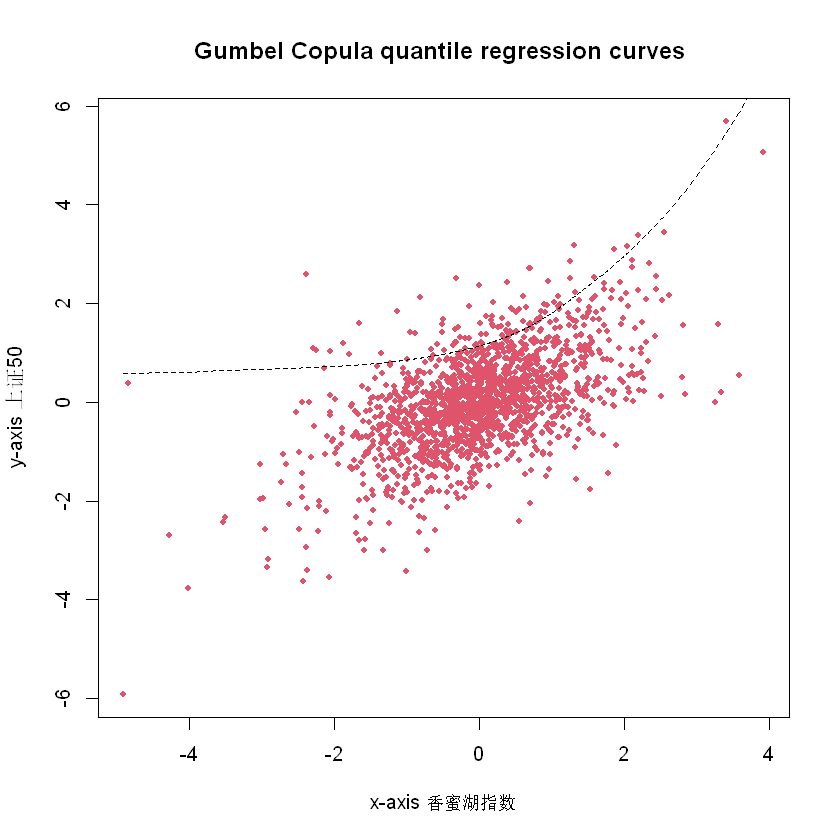

In [58]:
tau=0.95
fit1 <- nlrq(y1 ~ uGumbelModel(x, delta, mu, sigma, tau),
data=Dat1, tau=tau, start=list(delta = 1.1257506, mu = -0.1261274, sigma = 1.0103893), trace=TRUE)
plot(x, y1, main="Gumbel Copula quantile regression curves ", xlab="x-axis 香蜜湖指数", ylab="y-axis 上证50", type='p',col = 2, pch=20)
lines(x, predict(fit1, newdata=x), lty=2, lwd=1, col=1)
deltas[3,] <- coef(fit1)
summary(fit1)

In [59]:
# gumbel 评价
results <- calculate_aic_bic(fit1, Dat1, 0.95)

# 打印结果
cat("LLF:", results$LLF, "\n")
cat("AIC:", results$AIC, "\n")
cat("BIC:", results$BIC, "\n")

LLF: -4086.803 
AIC: 8179.607 
BIC: 8195.883 


In [60]:
######estimate the CoVaR######tau=0.05
tau <- 0.05
u_u <- c(0.5, 0.1, 0.05, 0.01)

delta <- coef(fit3)[1]
mu <- coef(fit3)[2]
sigma <- coef(fit3)[3]

v_f <- c(0, 0, 0, 0)
v_x <- c(0, 0, 0, 0)
for(i in 1:4)
{
rootf1<-function(v){1 - exp(-((-log(1 - u_u[i]))^delta + (-log(1 - v))^delta)^(1/delta)) * 
    (((-log(1 - u_u[i]))^delta + (-log(1 - v))^delta)^((1/delta) -
        1) * ((1/delta) * ((-log(1 - u_u[i]))^(delta - 1) * (delta *
        (1/(1 - u_u[i]))))))-tau}
vx<-uniroot(rootf1, c(0.00000001, 0.99999999))
v_x[i] <- vx$root
v_f[i] <- mistr_q(distribution(evt_stock), v_x[i])
}

z_u <- v_f

f_hat_u <- mu+sigma*z_u


In [61]:
###downside CoVaR
CoVaR_005_050 = fitted(filt_stock) + sigma(filt_stock)*f_hat_u[1]
CoVaR_005_010 = fitted(filt_stock) + sigma(filt_stock)*f_hat_u[2]
delta_CoVaR_005_010<-CoVaR_005_010-CoVaR_005_050

CoVaR_005_005 = fitted(filt_stock) + sigma(filt_stock)*f_hat_u[3]
delta_CoVaR_005_005<-CoVaR_005_005-CoVaR_005_050

CoVaR_005_001 = fitted(filt_stock) + sigma(filt_stock)*f_hat_u[4]
delta_CoVaR_005_001<-CoVaR_005_001-CoVaR_005_050

In [62]:
##  2  tau=0.95
tau <- 0.95

u_u <- c(0.5, 0.9, 0.95, 0.99)

delta <- coef(fit1)[1]
mu <- coef(fit1)[2]
sigma <- coef(fit1)[3]

v_f <- c(0, 0, 0, 0)
v_x <- c(0, 0, 0, 0)
for(i in 1:4)
{
rootf1 <- function(v){
exp(-((-log(u_u[i]))^delta + (-log(v))^delta)^(1/delta)) * (((-log(u_u[i]))^delta + 
   (-log(v))^delta)^((1/delta) - 1) * ((1/delta) * ((-log(u_u[i]))^(delta - 1) * (delta * (1/u_u[i])))))-tau
}
vx <- uniroot(rootf1, c(0.00000001, 0.99999999))
v_x[i] <- vx$root
v_f[i] <- mistr_q(distribution(evt_stock), v_x[i])
}

z_u <- v_f 

f_hat_u <- mu+sigma*z_u

In [63]:
###upside CoVaR
CoVaR_095_050 = fitted(filt_stock) + sigma(filt_stock)*f_hat_u[1]
CoVaR_095_010 = fitted(filt_stock) + sigma(filt_stock)*f_hat_u[2]
delta_CoVaR_095_010<-CoVaR_095_010-CoVaR_095_050

CoVaR_095_005 = fitted(filt_stock) + sigma(filt_stock)*f_hat_u[3]
delta_CoVaR_095_005<-CoVaR_095_005-CoVaR_095_050

CoVaR_095_001 = fitted(filt_stock) + sigma(filt_stock)*f_hat_u[4]
delta_CoVaR_095_001 <- CoVaR_095_001-CoVaR_095_050

           CoVaR_005_050 CoVaR_005_005 delta_CoVaR_005_005 CoVaR_095_050
2017-05-31     -1.464274     -2.481541          -1.0172668      1.368066
2017-06-01     -1.464606     -2.481873          -1.0172668      1.367734
2017-06-02     -1.438037     -2.432295          -0.9942579      1.330240
2017-06-05     -1.456088     -2.462205          -1.0061174      1.345210
2017-06-06     -1.459581     -2.489956          -1.0303756      1.409258
2017-06-07     -1.441891     -2.444589          -1.0026983      1.349887
           CoVaR_095_005 delta_CoVaR_095_005
2017-05-31      2.973643            1.605577
2017-06-01      2.973311            1.605577
2017-06-02      2.899501            1.569261
2017-06-05      2.933189            1.587979
2017-06-06      3.035524            1.626266
2017-06-07      2.932469            1.582583

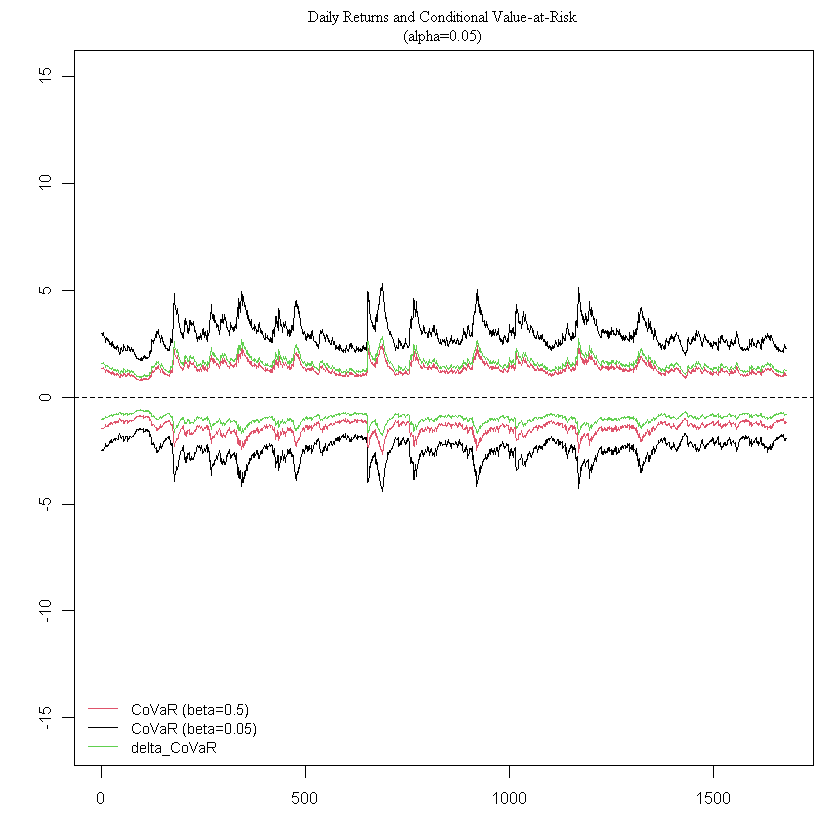

In [91]:
##plot the dynamic CoVaR and delta CoVaR
op <- par(mfrow=c(1,1), mgp=c(1.5, 0.8,0), mar= .1+c(3,3,2,1),
font.main=6, font.lab=6)
n <- length(ts_df_1$stock)
tt <- seq(1:length(ts_df_1$stock))
plot(tt,ts_df$stock, type = "n", main =paste('Daily Returns and Conditional Value-at-Risk\n',
    "(alpha=", 0.05, ")", sep = ""), ylab = '', xlab = '', xlim=c(1,n),
            ylim = c(-16, 15), 
           cex.main = 0.8,  cex.lab = 0.9, cex.axis = 0.8)
        points(ts_df$stock, pch = 19, col = 'gray', cex=0.5)
        abline(h = 0, col = "1", lty = 2)
lines(tt,CoVaR_005_005, lwd = 1, col = 1)
lines(tt,CoVaR_005_050, lwd = 1, col = 2,lty=1)
lines(tt,delta_CoVaR_005_005, lwd = 1, col = 3,lty=1)
lines(tt,CoVaR_095_005, lwd = 1, col = 1)
lines(tt,CoVaR_095_050, lwd = 1, col = 2,lty=1)
lines(tt,delta_CoVaR_095_005, lwd = 1, col = 3,lty=1)

legend("bottomleft", c("CoVaR (beta=0.5)", "CoVaR (beta=0.05)", 
            "delta_CoVaR"), col = c("2", "1", "3"), cex = 0.75, 
          lty = c(1, 1, 1), lwd = c(1, 1, 1), bty = "n")

dynamic <- cbind(CoVaR_005_050,CoVaR_005_005,delta_CoVaR_005_005,
CoVaR_095_050, CoVaR_095_005,delta_CoVaR_095_005,
ts_df$stock)

head(dynamic)

In [ ]:
ks_test_result <- ks.test(delta_CoVaR_005_005, "pnorm", mean = 0, sd = sd(delta_CoVaR_005_005))

print(ks_test_result)


	Asymptotic one-sample Kolmogorov-Smirnov test

data:  delta_CoVaR_005_005
D = 0.99993, p-value < 2.2e-16
alternative hypothesis: two-sided



In [ ]:
ks_test_result <- ks.test(delta_CoVaR_095_005, "pnorm", mean = 0, sd = sd(delta_CoVaR_095_005))

print(ks_test_result)


	Asymptotic one-sample Kolmogorov-Smirnov test

data:  delta_CoVaR_095_005
D = 1, p-value < 2.2e-16
alternative hypothesis: two-sided



Clayton copula及rotated clayton copula

In [ ]:
# clayton copula
if(!exists("deltas") || !is.matrix(deltas)) {
    deltas <- matrix(NA, nrow = 10, ncol = 3)  # 调整行数和列数
}

ClaytonModel <- function(x, delta, mu, sigma, tau) {
  v <- matrix(0, length(u), 1)
  u <- p(distribution(evt_fintech), x)
  for(i in 1:length(u)) {
    rootf1 <- function(v) {
      (1 + u[i]^delta * (v^(-delta) - 1))^(-1 / delta - 1) - tau
    }
    vx <- uniroot(rootf1, c(0.00000000001, 0.999999999999))
    v[i,1] <- vx$root
  }
  z <- mistr_q(distribution(evt_stock), v)
  mu + sigma * z
}

140.6582 :   1.1257506 -0.1261274  1.0103893 
final  value 140.412419 
stopped after 5 iterations
lambda = 0.04774767 
140.4124 :   1.2862856 -0.1504740  0.9916446 
final  value 140.272599 
stopped after 3 iterations
lambda = 0.4917871 
140.2726 :   1.6824011 -0.2977268  0.9861719 
final  value 140.272599 
converged
lambda = 0 
140.2726 :   1.6824011 -0.2977268  0.9861719 



Call: nlrq(formula = y1 ~ ClaytonModel(x, delta, mu, sigma, tau), data = Dat1, 
    start = list(delta = 1.1257506, mu = -0.1261274, sigma = 1.0103893), 
    tau = tau, trace = TRUE, control = list(maxiter = 100, k = 2, 
        InitialStepSize = 1, big = 1e+20, eps = 1e-07, beta = 0.97))

tau: [1] 0.05

Coefficients:
      Value    Std. Error t value  Pr(>|t|)
delta  1.68240  1.42987    1.17661  0.23952
mu    -0.29773  0.43492   -0.68455  0.49372
sigma  0.98617  0.11071    8.90808  0.00000

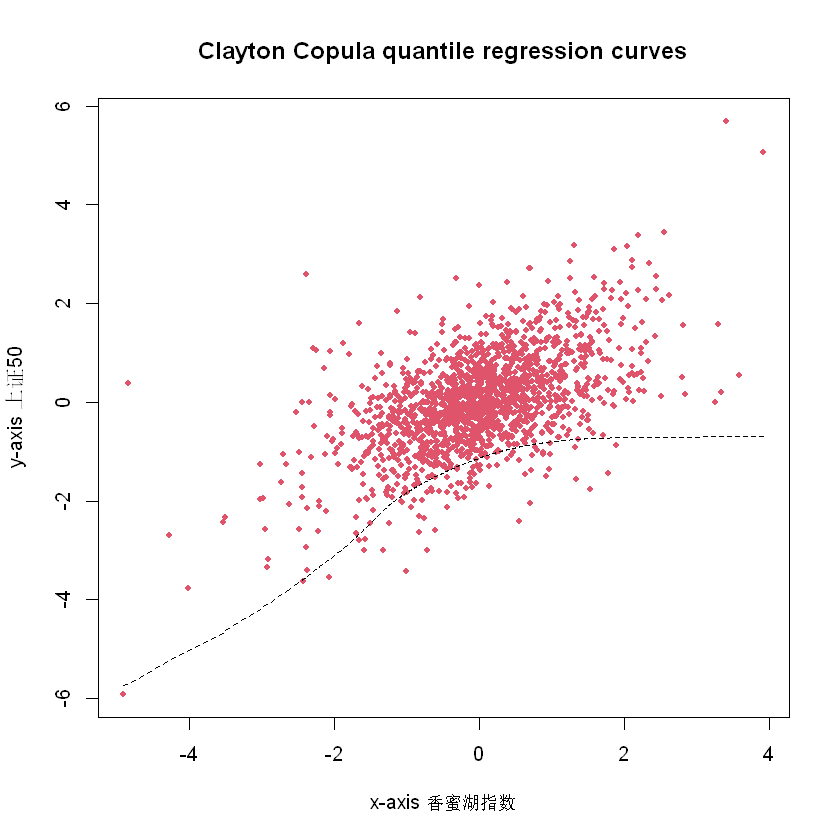

In [ ]:
tau <- 0.05

# 使用Clayton Copula的模型函数
ClaytonModel <- function(x, delta, mu, sigma, tau) {
  v <- matrix(0, length(x), 1)
  u <- p(distribution(evt_fintech), x)
  for(i in 1:length(u)) {
    rootf1 <- function(v) {
      (1 + u[i]^delta * (v^(-delta) - 1))^(-1 / delta - 1) - tau
    }
    vx <- uniroot(rootf1, c(0.00000000001, 0.999999999999))
    v[i,1] <- vx$root
  }
  z <- mistr_q(distribution(evt_stock), v)
  mu + sigma * z
}

# 拟合模型
fit3 <- nlrq(y1 ~ ClaytonModel(x, delta, mu, sigma, tau), 
             data = Dat1, tau = tau, start = list(delta = 1.1257506, mu = -0.1261274, sigma = 1.0103893), trace = TRUE)

# 绘图
plot(x, y1, main = "Clayton Copula quantile regression curves", 
     xlab = "x-axis 香蜜湖指数", ylab = "y-axis 上证50", type = 'p', col = 2, pch = 20)
lines(x, predict(fit3, newdata = data.frame(x = x)), lty = 2, lwd = 1, col = 1)

# 保存系数
deltas[3,] <- coef(fit3)

# 输出模型摘要
summary(fit3)


In [ ]:
# clayton 
results <- calculate_aic_bic(fit3, Dat1, 0.05)

cat("LLF:", results$LLF, "\n")
cat("AIC:", results$AIC, "\n")
cat("BIC:", results$BIC, "\n")

LLF: -4069.206 
AIC: 8144.413 
BIC: 8160.689 


155.2976 :   1.1257506 -0.1261274  1.0103893 
final  value 155.297560 
converged
lambda = 0 
155.2976 :   1.1257506 -0.1261274  1.0103893 



Call: nlrq(formula = y1 ~ uRotatedClaytonModel(x, delta, mu, sigma, 
    tau), data = Dat1, start = list(delta = 1.1257506, mu = -0.1261274, 
    sigma = 1.0103893), tau = tau, trace = TRUE, control = list(
    maxiter = 100, k = 2, InitialStepSize = 1, big = 1e+20, eps = 1e-07, 
    beta = 0.97))

tau: [1] 0.95

Coefficients:
      Value    Std. Error t value  Pr(>|t|)
delta  1.12575  1.21143    0.92928  0.35288
mu    -0.12613  0.59308   -0.21267  0.83161
sigma  1.01039  0.17109    5.90555  0.00000

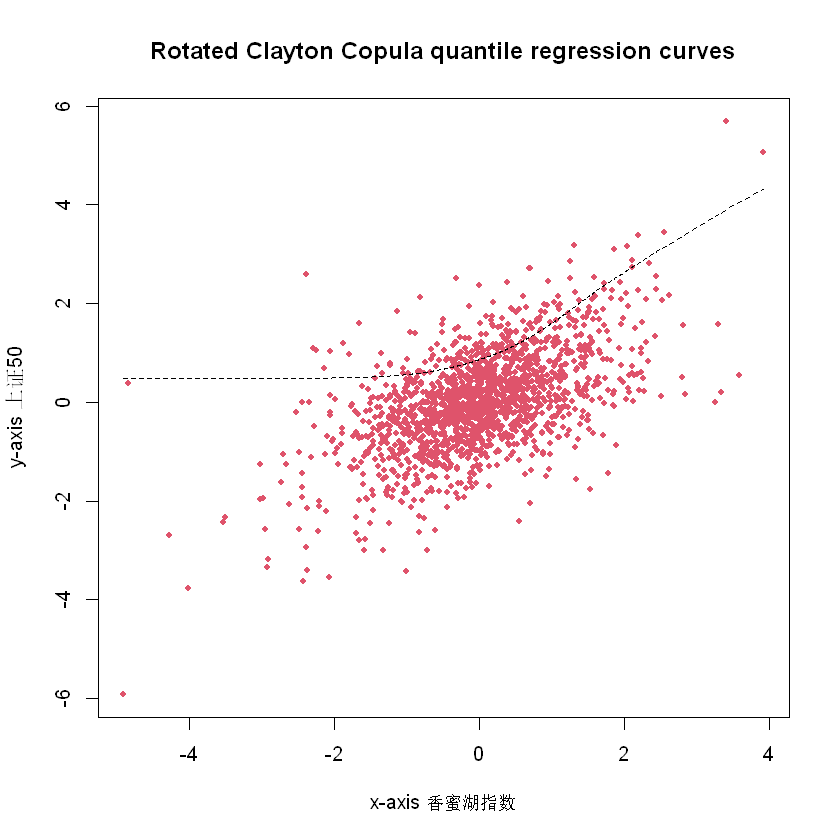

In [ ]:
tau <- 0.95

# Rotated Clayton copula quantile regression model
u <- p(distribution(evt_fintech), x)
uRotatedClaytonModel <- function(x, delta, mu, sigma, tau) {
  v <- matrix(0, length(u), 1)
  u <- p(distribution(evt_fintech), x)
  for (i in 1:length(u)) {
    rootf1 <- function(v) {
      1 - (1 + (1 - u[i])^delta * ((1 - v)^(-delta) - 1))^(-1 / delta - 1) - tau
    }
    vx <- uniroot(rootf1, c(0.000000001, 0.9999999999))
    v[i, 1] <- vx$root
  }
  z <- mistr_q(distribution(evt_stock), v)
  mu + sigma * z
}

# 拟合模型
fit1 <- nlrq(y1 ~ uRotatedClaytonModel(x, delta, mu, sigma, tau),
             data = Dat1, tau = tau, start = list(delta = 1.1257506, mu = -0.1261274, sigma = 1.0103893), trace = TRUE)

# 绘图
plot(x, y1, main = "Rotated Clayton Copula quantile regression curves", 
     xlab = "x-axis 香蜜湖指数", ylab = "y-axis 上证50", type = 'p', col = 2, pch = 20)
lines(x, predict(fit1, newdata = data.frame(x = x)), lty = 2, lwd = 1, col = 1)

# 保存系数
deltas[3,] <- coef(fit1)

# 输出模型摘要
summary(fit1)



In [ ]:
# rotated clayton 评价
results <- calculate_aic_bic(fit1, Dat1, 0.95)

cat("LLF:", results$LLF, "\n")
cat("AIC:", results$AIC, "\n")
cat("BIC:", results$BIC, "\n")

LLF: -3364.994 
AIC: 6735.987 
BIC: 6752.263 


In [ ]:
######estimate the CoVaR######tau=0.05
tau <- 0.05
u_u <- c(0.5, 0.1, 0.05, 0.01)

delta <- coef(fit3)[1]
mu <- coef(fit3)[2]
sigma <- coef(fit3)[3]

v_f <- c(0, 0, 0, 0)
v_x <- c(0, 0, 0, 0)
for(i in 1:4)
{
rootf1 <- function(v) {
  (1 + u_u[i]^delta * (v^(-delta) - 1))^(-1 / delta - 1) - tau
}
vx <- uniroot(rootf1, c(0.00000001, 0.99999999))
v_x[i] <- vx$root
v_f[i] <- mistr_q(distribution(evt_stock), v_x[i])
}

z_u <- v_f

f_hat_u <- mu + sigma * z_u


In [ ]:
###downside CoVaR
CoVaR_005_050 = fitted(filt_stock) + sigma(filt_stock)*f_hat_u[1]
CoVaR_005_010 = fitted(filt_stock) + sigma(filt_stock)*f_hat_u[2]
delta_CoVaR_005_010<-CoVaR_005_010-CoVaR_005_050

CoVaR_005_005 = fitted(filt_stock) + sigma(filt_stock)*f_hat_u[3]
delta_CoVaR_005_005<-CoVaR_005_005-CoVaR_005_050

CoVaR_005_001 = fitted(filt_stock) + sigma(filt_stock)*f_hat_u[4]
delta_CoVaR_005_001<-CoVaR_005_001-CoVaR_005_050

In [ ]:
##  2  tau=0.95
tau <- 0.95

u_u <- c(0.5, 0.9, 0.95, 0.99)

delta <- coef(fit1)[1]
mu <- coef(fit1)[2]
sigma <- coef(fit1)[3]

v_f <- c(0, 0, 0, 0)
v_x <- c(0, 0, 0, 0)
for(i in 1:4)
{
  rootf1 <- function(v) {
    1 - (1 + (1 - u_u[i])^delta * ((1 - v)^(-delta) - 1))^(-1 / delta - 1) - tau
  }
  vx <- uniroot(rootf1, c(0.00000001, 0.99999999))
  v_x[i] <- vx$root
  v_f[i] <- mistr_q(distribution(evt_stock), v_x[i])
}

z_u <- v_f 

f_hat_u <- mu + sigma * z_u


In [ ]:
###upside CoVaR
CoVaR_095_050 = fitted(filt_stock) + sigma(filt_stock)*f_hat_u[1]
CoVaR_095_010 = fitted(filt_stock) + sigma(filt_stock)*f_hat_u[2]
delta_CoVaR_095_010<-CoVaR_095_010-CoVaR_095_050

CoVaR_095_005 = fitted(filt_stock) + sigma(filt_stock)*f_hat_u[3]
delta_CoVaR_095_005<-CoVaR_095_005-CoVaR_095_050

CoVaR_095_001 = fitted(filt_stock) + sigma(filt_stock)*f_hat_u[4]
delta_CoVaR_095_001 <- CoVaR_095_001-CoVaR_095_050

           CoVaR_005_050 CoVaR_005_005 delta_CoVaR_005_005 CoVaR_095_050
2017-05-31     -1.350131     -3.048466           -1.698336      1.037529
2017-06-01     -1.350460     -3.048796           -1.698336      1.037199
2017-06-02     -1.326469     -2.986390           -1.659921      1.007184
2017-06-05     -1.343200     -3.022922           -1.679722      1.018291
2017-06-06     -1.343976     -3.064197           -1.720221      1.074452
2017-06-07     -1.329379     -3.003393           -1.674014      1.024087
           CoVaR_095_005 delta_CoVaR_095_005
2017-05-31      2.691320            1.653791
2017-06-01      2.690991            1.653791
2017-06-02      2.623568            1.616384
2017-06-05      2.653957            1.635666
2017-06-06      2.749555            1.675103
2017-06-07      2.654194            1.630107

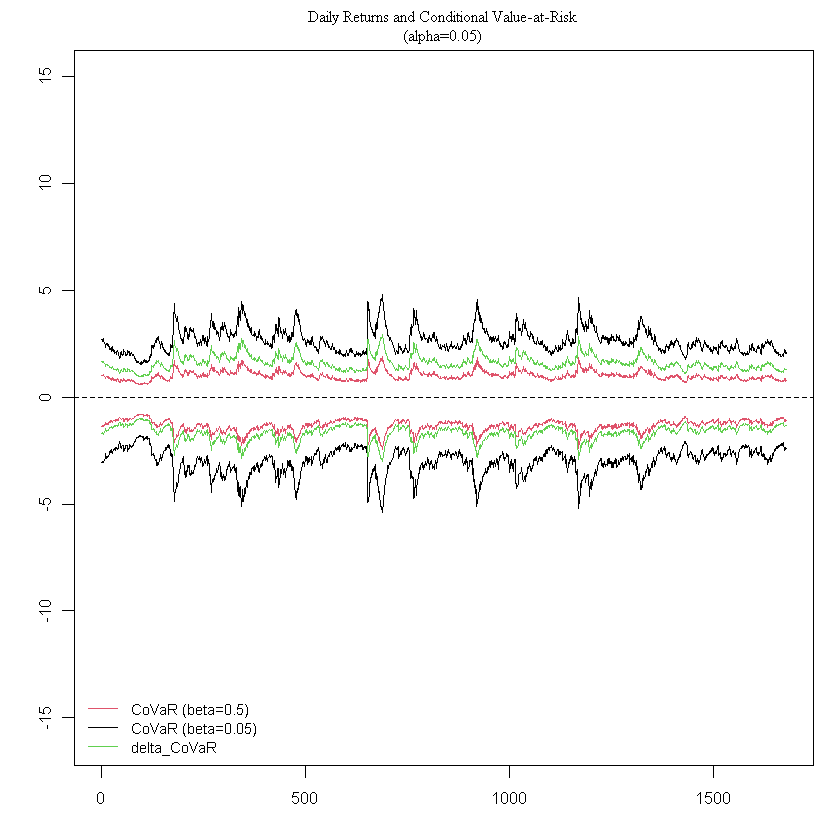

In [ ]:
##plot the dynamic CoVaR and delta CoVaR
op <- par(mfrow=c(1,1), mgp=c(1.5, 0.8,0), mar= .1+c(3,3,2,1),
font.main=6, font.lab=6)
n <- length(ts_df_1$stock)
tt <- seq(1:length(ts_df_1$stock))
plot(tt,ts_df$stock, type = "n", main =paste('Daily Returns and Conditional Value-at-Risk\n',
    "(alpha=", 0.05, ")", sep = ""), ylab = '', xlab = '', xlim=c(1,n),
            ylim = c(-16, 15), 
           cex.main = 0.8,  cex.lab = 0.9, cex.axis = 0.8)
        points(ts_df$stock, pch = 19, col = 'gray', cex=0.5)
        abline(h = 0, col = "1", lty = 2)
lines(tt,CoVaR_005_005, lwd = 1, col = 1)
lines(tt,CoVaR_005_050, lwd = 1, col = 2,lty=1)
lines(tt,delta_CoVaR_005_005, lwd = 1, col = 3,lty=1)
lines(tt,CoVaR_095_005, lwd = 1, col = 1)
lines(tt,CoVaR_095_050, lwd = 1, col = 2,lty=1)
lines(tt,delta_CoVaR_095_005, lwd = 1, col = 3,lty=1)

legend("bottomleft", c("CoVaR (beta=0.5)", "CoVaR (beta=0.05)", 
            "delta_CoVaR"), col = c("2", "1", "3"), cex = 0.75, 
          lty = c(1, 1, 1), lwd = c(1, 1, 1), bty = "n")

dynamic <- cbind(CoVaR_005_050,CoVaR_005_005,delta_CoVaR_005_005,
CoVaR_095_050, CoVaR_095_005,delta_CoVaR_095_005,
ts_df$stock)

head(dynamic)

In [ ]:
ks_test_result <- ks.test(delta_CoVaR_005_005, "pnorm", mean = 0, sd = sd(delta_CoVaR_005_005))

print(ks_test_result)


	Asymptotic one-sample Kolmogorov-Smirnov test

data:  delta_CoVaR_005_005
D = 0.99993, p-value < 2.2e-16
alternative hypothesis: two-sided



In [ ]:
ks_test_result <- ks.test(delta_CoVaR_095_005, "pnorm", mean = 0, sd = sd(delta_CoVaR_095_005))

print(ks_test_result)


	Asymptotic one-sample Kolmogorov-Smirnov test

data:  delta_CoVaR_095_005
D = 1, p-value < 2.2e-16
alternative hypothesis: two-sided



Joe & rotated joe

158.3064 :   1.1257506 -0.1261274  1.0103893 
iter   10 value 151.230059
final  value 151.230059 
stopped after 10 iterations
lambda = 0.2065869 
151.2301 :   1.18257247 -0.02623884  0.89890825 
final  value 149.502551 
converged
lambda = 0.2597655 
149.5026 :   1.3376733 -0.2656878  0.7714511 
final  value 145.583788 
converged
lambda = 0.8820985 
145.5838 :   2.0383447 -0.5326658  0.7715491 
final  value 144.922443 
converged
lambda = 0.115652 
144.9224 :   2.6483792 -0.6737508  0.7565358 
final  value 142.876149 
stopped after 6 iterations
lambda = 0.7924562 
142.8761 :   4.8516584 -0.8644388  0.8547681 
final  value 139.942302 
converged
lambda = 1 
139.9423 :   6.6000998 -0.7605676  0.9737864 
final  value 139.782672 
converged
lambda = 1 
139.7827 :   4.5485088 -0.5780334  1.0184965 
final  value 139.762331 
converged
lambda = 1 
139.7623 :   4.2229245 -0.5307616  1.0289967 
final  value 139.764282 
converged
lambda = 0.3444239 
139.7643 :   3.9675770 -0.4988495  1.0351259 



Call: nlrq(formula = y1 ~ RotatedJoeModel(x, delta, mu, sigma, tau), 
    data = Dat1, start = list(delta = 1.1257506, mu = -0.1261274, 
        sigma = 1.0103893), tau = tau, trace = TRUE, control = list(
        maxiter = 100, k = 2, InitialStepSize = 1, big = 1e+20, 
        eps = 1e-07, beta = 0.97))

tau: [1] 0.05

Coefficients:
      Value    Std. Error t value  Pr(>|t|)
delta  3.96758  2.01201    1.97194  0.04878
mu    -0.49885  0.33456   -1.49108  0.13613
sigma  1.03513  0.11558    8.95611  0.00000

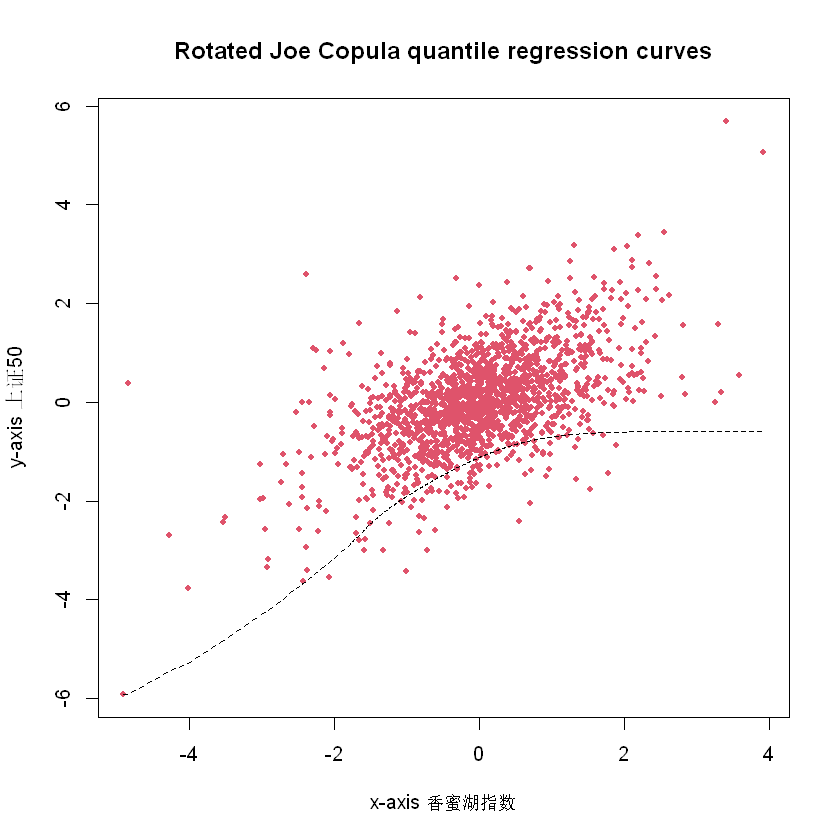

In [ ]:
# Rotated Joe copula
if(!exists("deltas") || !is.matrix(deltas)) {
    deltas <- matrix(NA, nrow = 10, ncol = 3)  # 调整行数和列数
}

RotatedJoeModel <- function(x, delta, mu, sigma, tau) {
  v <- matrix(0, length(u), 1)
  u <- p(distribution(evt_fintech), x)
  for(i in 1:length(u)) {
    rootf1 <- function(v) {
      term1 <- 1 + u[i]^(-delta) * v^delta - v^delta
      term2 <- (1 - v^delta)
      1 - (term1)^((1 - delta) / delta) * term2 - tau
    }
    vx <- uniroot(rootf1, c(0.00000000001, 0.999999999999))
    v[i,1] <- vx$root
  }
  z <- mistr_q(distribution(evt_stock), v)
  mu + sigma * z
}

tau <- 0.05
# 拟合模型
fit3 <- nlrq(y1 ~ RotatedJoeModel(x, delta, mu, sigma, tau),
             data = Dat1, tau = tau, start = list(delta = 1.1257506, mu = -0.1261274, sigma = 1.0103893), trace = TRUE)

# 绘图
plot(x, y1, main = "Rotated Joe Copula quantile regression curves", 
     xlab = "x-axis 香蜜湖指数", ylab = "y-axis 上证50", type = 'p', col = 2, pch = 20)
lines(x, predict(fit3, newdata = data.frame(x = x)), lty = 2, lwd = 1, col = 1)

# 保存系数
deltas[3,] <- coef(fit3)

# 输出模型摘要
summary(fit3)


In [ ]:
# rotated joe copula 评价
results <- calculate_aic_bic(fit3, Dat1, 0.05)

cat("LLF:", results$LLF, "\n")
cat("AIC:", results$AIC, "\n")
cat("BIC:", results$BIC, "\n")

LLF: -4024.972 
AIC: 8055.944 
BIC: 8072.22 


156.603 :   1.1257506 -0.1261274  1.0103893 
final  value 156.150866 
converged
lambda = 0.06906837 
156.1509 :   1.1454445 -0.1583642  0.9852161 
final  value 146.595180 
converged
lambda = 1 
146.5952 :   1.4626784 -0.0452639  1.0605111 
final  value 146.481506 
stopped after 3 iterations
lambda = 0.07031036 
146.4815 :  1.52812649 0.03756993 1.02334349 
final  value 144.628921 
converged
lambda = 1 
144.6289 :  2.1531478 0.2499877 1.0214350 
final  value 144.114112 
converged
lambda = 1 
144.1141 :  2.2213137 0.1670204 1.1095947 
final  value 143.857756 
converged
lambda = 0.561549 
143.8578 :  2.900001 0.338084 1.101182 
final  value 143.859654 
converged
lambda = 0.9765773 
143.8597 :  2.7822804 0.2963221 1.1180521 



Call: nlrq(formula = y1 ~ uJoeModel(x, delta, mu, sigma, tau), data = Dat1, 
    start = list(delta = 1.1257506, mu = -0.1261274, sigma = 1.0103893), 
    tau = tau, trace = TRUE, control = list(maxiter = 100, k = 2, 
        InitialStepSize = 1, big = 1e+20, eps = 1e-07, beta = 0.97))

tau: [1] 0.95

Coefficients:
      Value   Std. Error t value Pr(>|t|)
delta 2.78228 1.07795    2.58107 0.00993 
mu    0.29632 0.36071    0.82149 0.41148 
sigma 1.11805 0.15441    7.24058 0.00000 

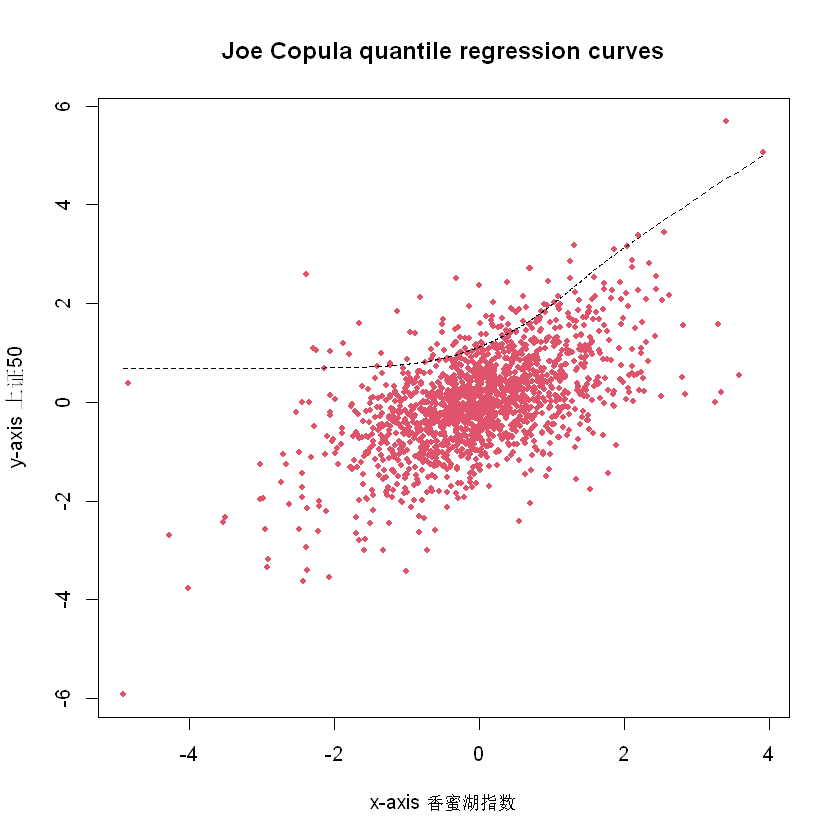

In [ ]:
tau <- 0.95

# Joe copula quantile regression model
u <- p(distribution(evt_fintech), x)
uJoeModel <- function(x, delta, mu, sigma, tau) {
  v <- matrix(0, length(u), 1)
  u <- p(distribution(evt_fintech), x)
  for (i in 1:length(u)) {
    rootf1 <- function(v) {
      term1 <- 1 + (1 - u[i])^(-delta) * (1 - v)^delta - (1 - v)^delta
      term2 <- (1 - (1 - v)^delta)
      (term1)^((1 - delta) / delta) * term2 - tau
    }
    vx <- uniroot(rootf1, c(0.000000001, 0.9999999999))
    v[i, 1] <- vx$root
  }
  z <- mistr_q(distribution(evt_stock), v)
  mu + sigma * z
}

# 拟合模型
fit1 <- nlrq(y1 ~ uJoeModel(x, delta, mu, sigma, tau),
             data = Dat1, tau = tau, start = list(delta = 1.1257506, mu = -0.1261274, sigma = 1.0103893), trace = TRUE)

# 绘图
plot(x, y1, main = "Joe Copula quantile regression curves", 
     xlab = "x-axis 香蜜湖指数", ylab = "y-axis 上证50", type = 'p', col = 2, pch = 20)
lines(x, predict(fit1, newdata = data.frame(x = x)), lty = 2, lwd = 1, col = 1)

# 保存系数
deltas[3,] <- coef(fit1)

# 输出模型摘要
summary(fit1)


In [ ]:
# joe copula 评价
results <- calculate_aic_bic(fit1, Dat1, 0.95)

cat("LLF:", results$LLF, "\n")
cat("AIC:", results$AIC, "\n")
cat("BIC:", results$BIC, "\n")

LLF: -4111.905 
AIC: 8229.809 
BIC: 8246.085 


In [ ]:
######estimate the CoVaR######tau=0.05
tau <- 0.05
u_u <- c(0.5, 0.1, 0.05, 0.01)

delta <- coef(fit3)[1]
mu <- coef(fit3)[2]
sigma <- coef(fit3)[3]

v_f <- c(0, 0, 0, 0)
v_x <- c(0, 0, 0, 0)
for(i in 1:4)
{
  rootf1 <- function(v) {
    term1 <- 1 + u_u[i]^(-delta) * v^delta - v^delta
    term2 <- (1 - v^delta)
    1 - (term1)^((1 - delta) / delta) * term2 - tau
  }
  vx <- uniroot(rootf1, c(0.00000001, 0.99999999))
  v_x[i] <- vx$root
  v_f[i] <- mistr_q(distribution(evt_stock), v_x[i])
}

z_u <- v_f

f_hat_u <- mu + sigma * z_u


In [ ]:
###downside CoVaR
CoVaR_005_050 = fitted(filt_stock) + sigma(filt_stock)*f_hat_u[1]
CoVaR_005_010 = fitted(filt_stock) + sigma(filt_stock)*f_hat_u[2]
delta_CoVaR_005_010<-CoVaR_005_010-CoVaR_005_050

CoVaR_005_005 = fitted(filt_stock) + sigma(filt_stock)*f_hat_u[3]
delta_CoVaR_005_005<-CoVaR_005_005-CoVaR_005_050

CoVaR_005_001 = fitted(filt_stock) + sigma(filt_stock)*f_hat_u[4]
delta_CoVaR_005_001<-CoVaR_005_001-CoVaR_005_050

In [ ]:
##  2  tau=0.95
tau <- 0.95

u_u <- c(0.5, 0.9, 0.95, 0.99)

delta <- coef(fit1)[1]
mu <- coef(fit1)[2]
sigma <- coef(fit1)[3]

v_f <- c(0, 0, 0, 0)
v_x <- c(0, 0, 0, 0)
for(i in 1:4)
{
  rootf1 <- function(v) {
    term1 <- 1 + (1 - u_u[i])^(-delta) * (1 - v)^delta - (1 - v)^delta
    term2 <- (1 - (1 - v)^delta)
    (term1)^((1 - delta) / delta) * term2 - tau
  }
  vx <- uniroot(rootf1, c(0.00000001, 0.99999999))
  v_x[i] <- vx$root
  v_f[i] <- mistr_q(distribution(evt_stock), v_x[i])
}

z_u <- v_f 

f_hat_u <- mu + sigma * z_u


In [ ]:
###upside CoVaR
CoVaR_095_050 = fitted(filt_stock) + sigma(filt_stock)*f_hat_u[1]
CoVaR_095_010 = fitted(filt_stock) + sigma(filt_stock)*f_hat_u[2]
delta_CoVaR_095_010<-CoVaR_095_010-CoVaR_095_050

CoVaR_095_005 = fitted(filt_stock) + sigma(filt_stock)*f_hat_u[3]
delta_CoVaR_095_005<-CoVaR_095_005-CoVaR_095_050

CoVaR_095_001 = fitted(filt_stock) + sigma(filt_stock)*f_hat_u[4]
delta_CoVaR_095_001 <- CoVaR_095_001-CoVaR_095_050

           CoVaR_005_050 CoVaR_005_005 delta_CoVaR_005_005 CoVaR_095_050
2017-05-31     -1.333568     -3.064771           -1.731202      1.350350
2017-06-01     -1.333898     -3.065100           -1.731202      1.350021
2017-06-02     -1.310281     -3.002325           -1.692044      1.312930
2017-06-05     -1.326819     -3.039048           -1.712228      1.327684
2017-06-06     -1.327200     -3.080712           -1.753512      1.391305
2017-06-07     -1.313054     -3.019464           -1.706410      1.332428
           CoVaR_095_005 delta_CoVaR_095_005
2017-05-31      3.234174            1.883824
2017-06-01      3.233845            1.883824
2017-06-02      3.154143            1.841214
2017-06-05      3.190861            1.863177
2017-06-06      3.299405            1.908100
2017-06-07      3.189274            1.856846

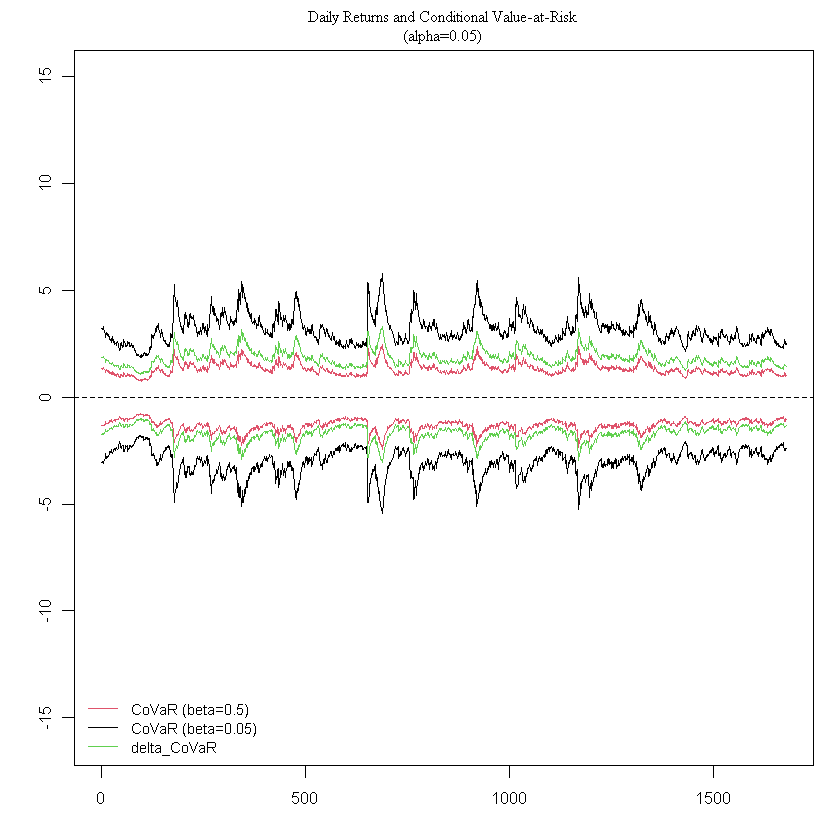

In [ ]:
##plot the dynamic CoVaR and delta CoVaR
op <- par(mfrow=c(1,1), mgp=c(1.5, 0.8,0), mar= .1+c(3,3,2,1),
font.main=6, font.lab=6)
n <- length(ts_df_1$stock)
tt <- seq(1:length(ts_df_1$stock))
plot(tt,ts_df$stock, type = "n", main =paste('Daily Returns and Conditional Value-at-Risk\n',
    "(alpha=", 0.05, ")", sep = ""), ylab = '', xlab = '', xlim=c(1,n),
            ylim = c(-16, 15), 
           cex.main = 0.8,  cex.lab = 0.9, cex.axis = 0.8)
        points(ts_df$stock, pch = 19, col = 'gray', cex=0.5)
        abline(h = 0, col = "1", lty = 2)
lines(tt,CoVaR_005_005, lwd = 1, col = 1)
lines(tt,CoVaR_005_050, lwd = 1, col = 2,lty=1)
lines(tt,delta_CoVaR_005_005, lwd = 1, col = 3,lty=1)
lines(tt,CoVaR_095_005, lwd = 1, col = 1)
lines(tt,CoVaR_095_050, lwd = 1, col = 2,lty=1)
lines(tt,delta_CoVaR_095_005, lwd = 1, col = 3,lty=1)

legend("bottomleft", c("CoVaR (beta=0.5)", "CoVaR (beta=0.05)", 
            "delta_CoVaR"), col = c("2", "1", "3"), cex = 0.75, 
          lty = c(1, 1, 1), lwd = c(1, 1, 1), bty = "n")

dynamic <- cbind(CoVaR_005_050,CoVaR_005_005,delta_CoVaR_005_005,
CoVaR_095_050, CoVaR_095_005,delta_CoVaR_095_005,
ts_df$stock)

head(dynamic)

In [ ]:
ks_test_result <- ks.test(delta_CoVaR_005_005, "pnorm", mean = 0, sd = sd(delta_CoVaR_005_005))

print(ks_test_result)


	Asymptotic one-sample Kolmogorov-Smirnov test

data:  delta_CoVaR_005_005
D = 0.99993, p-value < 2.2e-16
alternative hypothesis: two-sided



In [ ]:
ks_test_result <- ks.test(delta_CoVaR_095_005, "pnorm", mean = 0, sd = sd(delta_CoVaR_095_005))

print(ks_test_result)


	Asymptotic one-sample Kolmogorov-Smirnov test

data:  delta_CoVaR_095_005
D = 1, p-value < 2.2e-16
alternative hypothesis: two-sided



Galambos & rotated Galambos（没有合适步长）

Hüsler-Reiss copula 

303.4588 :   1.1257506 -0.1261274  1.0103893 
final  value 303.458828 
converged
lambda = 0 
303.4588 :   1.1257506 -0.1261274  1.0103893 



Call: nlrq(formula = y1 ~ RotatedHuslerReissModel(x, delta, mu, sigma, 
    tau), data = Dat1, start = list(delta = 1.1257506, mu = -0.1261274, 
    sigma = 1.0103893), tau = tau, trace = TRUE, control = list(
    maxiter = 100, k = 2, InitialStepSize = 1, big = 1e+20, eps = 1e-07, 
    beta = 0.97))

tau: [1] 0.05

Coefficients:
      Value    Std. Error t value  Pr(>|t|)
delta  1.12575  0.09404   11.97108  0.00000
mu    -0.12613  0.04876   -2.58689  0.00977
sigma  1.01039  0.08604   11.74268  0.00000

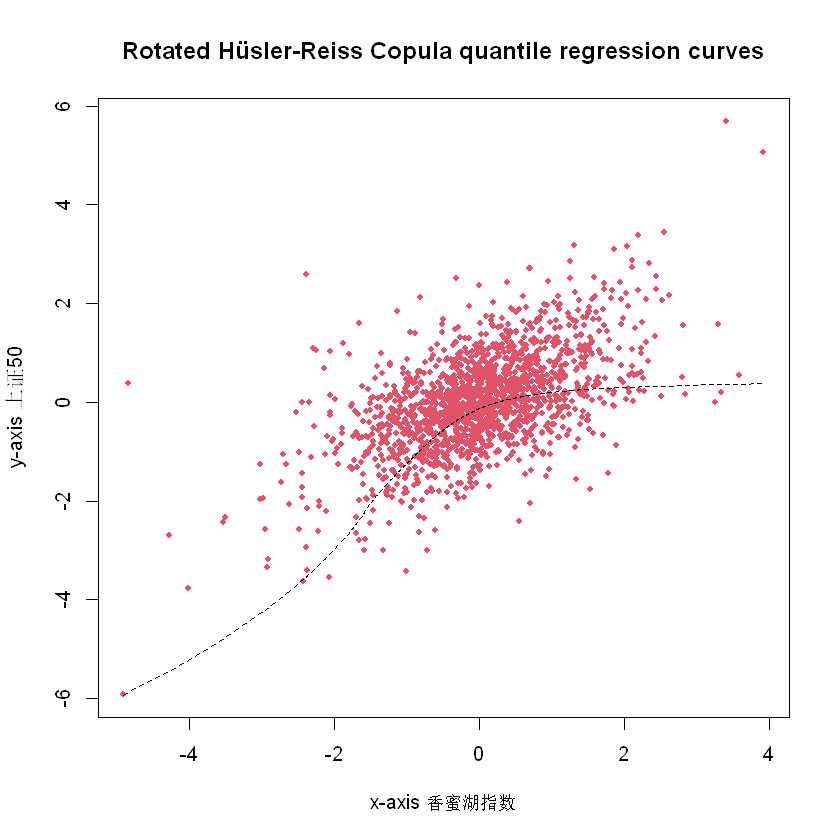

In [ ]:
# Rotated Hüsler-Reiss copula conditional distribution function
conditional_rotated_husler_reiss_copula <- function(u, v, delta) {
  phi <- pnorm(delta^-1 + 0.5 * delta * log(log(1 - u) / log(1 - v)))
  copula_value <- husler_reiss_copula(1 - u, 1 - v, delta)
  result <- 1 - copula_value * (1 - u)^-1 * phi
  return(result)
}

# Hüsler-Reiss copula
husler_reiss_copula <- function(u, v, delta) {
  exp(-(log(u) * log(v))^(1/delta))
}

# Rotated Hüsler-Reiss copula quantile regression model
if(!exists("deltas") || !is.matrix(deltas)) {
    deltas <- matrix(NA, nrow = 10, ncol = 3)  # 调整行数和列数
}

RotatedHuslerReissModel <- function(x, delta, mu, sigma, tau) {
  v <- matrix(0, length(x), 1)
  u <- p(distribution(evt_fintech), x)
  for(i in 1:length(u)) {
    rootf1 <- function(v) {
      conditional_rotated_husler_reiss_copula(u[i], v, delta) - tau
    }
    vx <- uniroot(rootf1, c(0.00000000001, 0.999999999999))
    v[i,1] <- vx$root
  }
  z <- mistr_q(distribution(evt_stock), v)
  mu + sigma * z
}

tau <- 0.05
# 拟合模型
fit3 <- nlrq(y1 ~ RotatedHuslerReissModel(x, delta, mu, sigma, tau),
             data = Dat1, tau = tau, start = list(delta = 1.1257506, mu = -0.1261274, sigma = 1.0103893), trace = TRUE)

# 绘图
plot(x, y1, main = "Rotated Hüsler-Reiss Copula quantile regression curves", 
     xlab = "x-axis 香蜜湖指数", ylab = "y-axis 上证50", type = 'p', col = 2, pch = 20)
lines(x, predict(fit3, newdata = data.frame(x = x)), lty = 2, lwd = 1, col = 1)

# 保存系数
deltas[3,] <- coef(fit3)

# 输出模型摘要
summary(fit3)


In [ ]:
# rotated husler-relss copula 评价
results <- calculate_aic_bic(fit3, Dat1, 0.05)

cat("LLF:", results$LLF, "\n")
cat("AIC:", results$AIC, "\n")
cat("BIC:", results$BIC, "\n")

LLF: -2447.901 
AIC: 4901.802 
BIC: 4918.078 


476.6391 :   1.1257506 -0.1261274  1.0103893 
final  value 385.582407 
converged
lambda = 1 
385.5824 :  1.37229852 0.03633232 0.58554078 
final  value 146.531946 
converged
lambda = 1 
146.5319 :  1.0719129 1.0612935 0.7566129 
final  value 144.968762 
converged
lambda = 1 
144.9688 :  1.1431665 1.0822699 0.8053093 
final  value 144.799009 
converged
lambda = 0.3165733 
144.799 :  1.1745882 1.0966255 0.7639018 
final  value 144.799009 
converged
lambda = 0 
144.799 :  1.1745882 1.0966255 0.7639018 



Call: nlrq(formula = y1 ~ HuslerReissModel(x, delta, mu, sigma, tau), 
    data = Dat1, start = list(delta = 1.1257506, mu = -0.1261274, 
        sigma = 1.0103893), tau = tau, trace = TRUE, control = list(
        maxiter = 100, k = 2, InitialStepSize = 1, big = 1e+20, 
        eps = 1e-07, beta = 0.97))

tau: [1] 0.95

Coefficients:
      Value    Std. Error t value  Pr(>|t|)
delta  1.17459  0.13363    8.78955  0.00000
mu     1.09663  0.05778   18.97790  0.00000
sigma  0.76390  0.07950    9.60906  0.00000

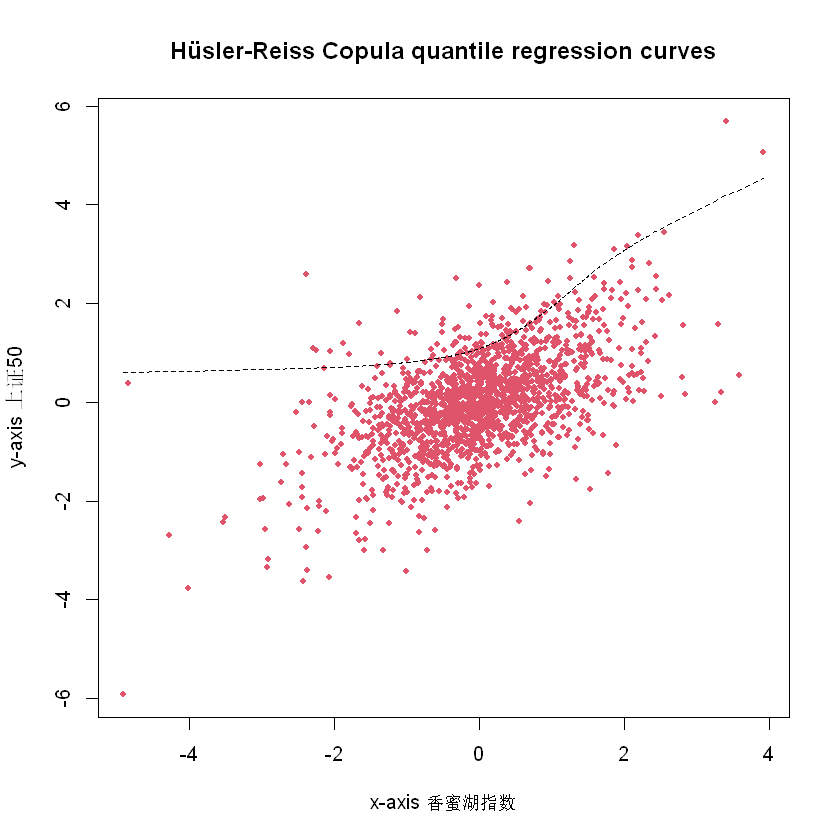

In [ ]:
# Hüsler-Reiss copula conditional distribution function
conditional_husler_reiss_copula <- function(u, v, delta) {
  phi_u <- pnorm(delta^-1 + 0.5 * delta * log(log(u) / log(v)))
  copula_value <- husler_reiss_copula(u, v, delta)
  result <- copula_value * u^-1 * phi_u
  return(result)
}

# Hüsler-Reiss copula
husler_reiss_copula <- function(u, v, delta) {
  exp(-(log(u) * log(v))^(1/delta))
}

# Hüsler-Reiss copula quantile regression model
if(!exists("deltas") || !is.matrix(deltas)) {
    deltas <- matrix(NA, nrow = 10, ncol = 3)  # 调整行数和列数
}

HuslerReissModel <- function(x, delta, mu, sigma, tau) {
  v <- matrix(0, length(u), 1)
  u <- p(distribution(evt_fintech), x)
  for (i in 1:length(u)) {
    rootf1 <- function(v) {
      conditional_husler_reiss_copula(u[i], v, delta) - tau
    }
    vx <- uniroot(rootf1, c(0.000000001, 0.9999999999))
    v[i, 1] <- vx$root
  }
  z <- mistr_q(distribution(evt_stock), v)
  mu + sigma * z
}

tau <- 0.95
# 拟合模型
fit1 <- nlrq(y1 ~ HuslerReissModel(x, delta, mu, sigma, tau),
             data = Dat1, tau = tau, start = list(delta = 1.1257506, mu = -0.1261274, sigma = 1.0103893), trace = TRUE)

# 绘图
plot(x, y1, main = "Hüsler-Reiss Copula quantile regression curves", 
     xlab = "x-axis 香蜜湖指数", ylab = "y-axis 上证50", type = 'p', col = 2, pch = 20)
lines(x, predict(fit1, newdata = data.frame(x = x)), lty = 2, lwd = 1, col = 1)

# 保存系数
deltas[3,] <- coef(fit1)

# 输出模型摘要
summary(fit1)

In [ ]:
#huler-reiss copula 评价
results <- calculate_aic_bic(fit1, Dat1, 0.95)

cat("LLF:", results$LLF, "\n")
cat("AIC:", results$AIC, "\n")
cat("BIC:", results$BIC, "\n")

LLF: -4064.588 
AIC: 8135.175 
BIC: 8151.451 


In [ ]:
# Hüsler-Reiss copula
husler_reiss_copula <- function(u, v, delta) {
  exp(-(log(u) * log(v))^(1/delta))
}

# Rotated Hüsler-Reiss copula conditional distribution function
conditional_rotated_husler_reiss_copula <- function(u, v, delta) {
  phi <- pnorm(delta^-1 + 0.5 * delta * log(log(1 - u) / log(1 - v)))
  copula_value <- husler_reiss_copula(1 - u, 1 - v, delta)
  result <- 1 - copula_value * (1 - u)^-1 * phi
  return(result)
}

######estimate the CoVaR######tau=0.05
tau <- 0.05
u_u <- c(0.5, 0.1, 0.05, 0.01)

delta <- coef(fit3)[1]
mu <- coef(fit3)[2]
sigma <- coef(fit3)[3]

v_f <- c(0, 0, 0, 0)
v_x <- c(0, 0, 0, 0)
for(i in 1:4) {
  rootf1 <- function(v) {
    conditional_rotated_husler_reiss_copula(u_u[i], v, delta) - tau
  }
  vx <- uniroot(rootf1, c(0.00000001, 0.99999999))
  v_x[i] <- vx$root
  v_f[i] <- mistr_q(distribution(evt_stock), v_x[i])
}

z_u <- v_f

f_hat_u <- mu + sigma * z_u


In [ ]:
###downside CoVaR
CoVaR_005_050 = fitted(filt_stock) + sigma(filt_stock)*f_hat_u[1]
CoVaR_005_010 = fitted(filt_stock) + sigma(filt_stock)*f_hat_u[2]
delta_CoVaR_005_010<-CoVaR_005_010-CoVaR_005_050

CoVaR_005_005 = fitted(filt_stock) + sigma(filt_stock)*f_hat_u[3]
delta_CoVaR_005_005<-CoVaR_005_005-CoVaR_005_050

CoVaR_005_001 = fitted(filt_stock) + sigma(filt_stock)*f_hat_u[4]
delta_CoVaR_005_001<-CoVaR_005_001-CoVaR_005_050

In [ ]:
# Hüsler-Reiss copula
husler_reiss_copula <- function(u, v, delta) {
  exp(-(log(u) * log(v))^(1/delta))
}

# Hüsler-Reiss copula conditional distribution function
conditional_husler_reiss_copula <- function(u, v, delta) {
  phi_u <- pnorm(delta^-1 + 0.5 * delta * log(log(u) / log(v)))
  copula_value <- husler_reiss_copula(u, v, delta)
  result <- copula_value * u^-1 * phi_u
  return(result)
}

##  2  tau=0.95
tau <- 0.95

u_u <- c(0.5, 0.9, 0.95, 0.99)

delta <- coef(fit1)[1]
mu <- coef(fit1)[2]
sigma <- coef(fit1)[3]

v_f <- c(0, 0, 0, 0)
v_x <- c(0, 0, 0, 0)
for(i in 1:4) {
  rootf1 <- function(v) {
    conditional_husler_reiss_copula(u_u[i], v, delta) - tau
  }
  vx <- uniroot(rootf1, c(0.00000001, 0.99999999))
  v_x[i] <- vx$root
  v_f[i] <- mistr_q(distribution(evt_stock), v_x[i])
}

z_u <- v_f 

f_hat_u <- mu + sigma * z_u


In [ ]:
###upside CoVaR
CoVaR_095_050 = fitted(filt_stock) + sigma(filt_stock)*f_hat_u[1]
CoVaR_095_010 = fitted(filt_stock) + sigma(filt_stock)*f_hat_u[2]
delta_CoVaR_095_010<-CoVaR_095_010-CoVaR_095_050

CoVaR_095_005 = fitted(filt_stock) + sigma(filt_stock)*f_hat_u[3]
delta_CoVaR_095_005<-CoVaR_095_005-CoVaR_095_050

CoVaR_095_001 = fitted(filt_stock) + sigma(filt_stock)*f_hat_u[4]
delta_CoVaR_095_001 <- CoVaR_095_001-CoVaR_095_050

           CoVaR_005_050 CoVaR_005_005 delta_CoVaR_005_005 CoVaR_095_050
2017-05-31    -0.1473972     -2.628571           -2.481174      1.311070
2017-06-01    -0.1477269     -2.628901           -2.481174      1.310740
2017-06-02    -0.1509401     -2.575992           -2.425052      1.274537
2017-06-05    -0.1536486     -2.607629           -2.453980      1.288833
2017-06-06    -0.1257435     -2.638891           -2.513148      1.351518
2017-06-07    -0.1438702     -2.589511           -2.445641      1.293710
           CoVaR_095_005 delta_CoVaR_095_005
2017-05-31      3.211083            1.900013
2017-06-01      3.210753            1.900013
2017-06-02      3.131574            1.857037
2017-06-05      3.168023            1.879189
2017-06-06      3.276016            1.924498
2017-06-07      3.166513            1.872803

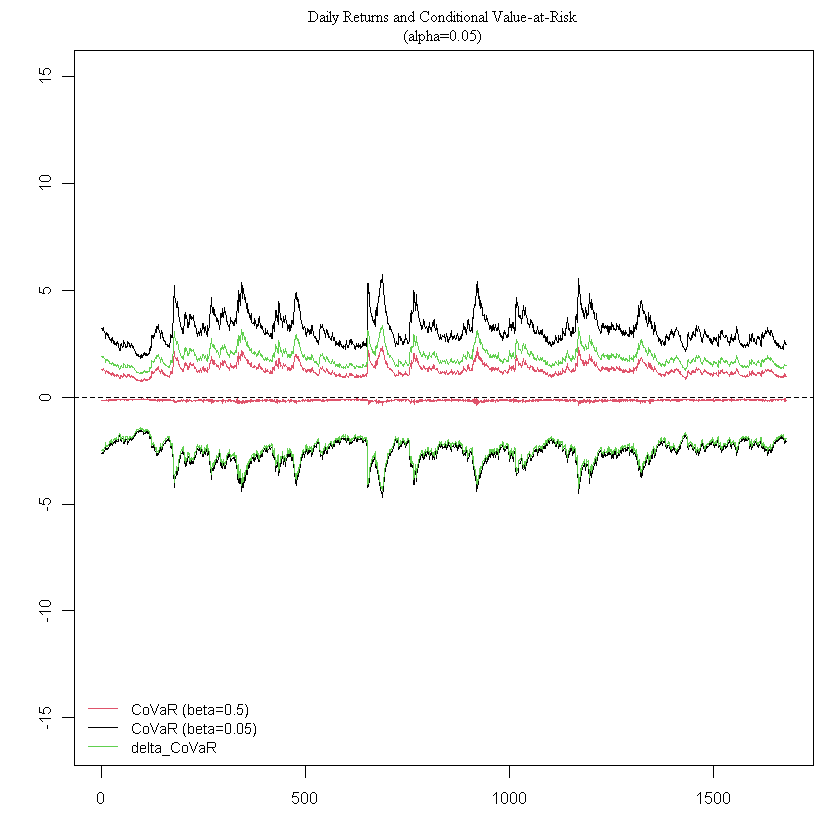

In [ ]:
##plot the dynamic CoVaR and delta CoVaR
op <- par(mfrow=c(1,1), mgp=c(1.5, 0.8,0), mar= .1+c(3,3,2,1),
font.main=6, font.lab=6)
n <- length(ts_df_1$stock)
tt <- seq(1:length(ts_df_1$stock))
plot(tt,ts_df$stock, type = "n", main =paste('Daily Returns and Conditional Value-at-Risk\n',
    "(alpha=", 0.05, ")", sep = ""), ylab = '', xlab = '', xlim=c(1,n),
            ylim = c(-16, 15), 
           cex.main = 0.8,  cex.lab = 0.9, cex.axis = 0.8)
        points(ts_df$stock, pch = 19, col = 'gray', cex=0.5)
        abline(h = 0, col = "1", lty = 2)
lines(tt,CoVaR_005_005, lwd = 1, col = 1)
lines(tt,CoVaR_005_050, lwd = 1, col = 2,lty=1)
lines(tt,delta_CoVaR_005_005, lwd = 1, col = 3,lty=1)
lines(tt,CoVaR_095_005, lwd = 1, col = 1)
lines(tt,CoVaR_095_050, lwd = 1, col = 2,lty=1)
lines(tt,delta_CoVaR_095_005, lwd = 1, col = 3,lty=1)

legend("bottomleft", c("CoVaR (beta=0.5)", "CoVaR (beta=0.05)", 
            "delta_CoVaR"), col = c("2", "1", "3"), cex = 0.75, 
          lty = c(1, 1, 1), lwd = c(1, 1, 1), bty = "n")

dynamic <- cbind(CoVaR_005_050,CoVaR_005_005,delta_CoVaR_005_005,
CoVaR_095_050, CoVaR_095_005,delta_CoVaR_095_005,
ts_df$stock)

head(dynamic)

In [ ]:
ks_test_result <- ks.test(delta_CoVaR_095_005, "pnorm", mean = 0, sd = sd(delta_CoVaR_095_005))

print(ks_test_result)


	Asymptotic one-sample Kolmogorov-Smirnov test

data:  delta_CoVaR_095_005
D = 1, p-value < 2.2e-16
alternative hypothesis: two-sided



In [ ]:
ks_test_result <- ks.test(delta_CoVaR_005_005, "pnorm", mean = 0, sd = sd(delta_CoVaR_005_005))

print(ks_test_result)


	Asymptotic one-sample Kolmogorov-Smirnov test

data:  delta_CoVaR_005_005
D = 0.99993, p-value < 2.2e-16
alternative hypothesis: two-sided



下尾选clayton 上尾选huster
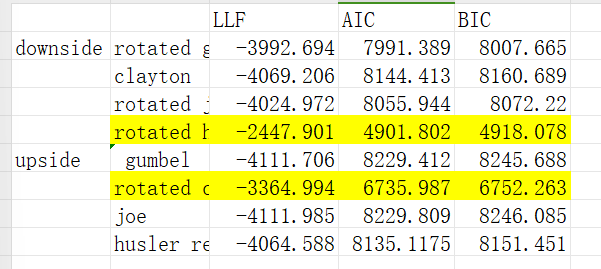

？输出covar的图像看着波动的很奇怪，还有就是上尾下尾选不同的copula应该也可以吧（就是不是gumbel和rotated gumbel这种一组的）

galambos_copula？这个代码跑不出结果 不太清楚怎么改。。这里倒是不太影响只有上面那四个比较也ok 但是考虑到毕业论文可能还是得搞一下

In [ ]:
# Galambos copula
galambos_copula <- function(u, v, delta) {
  exp(-(((-log(u))^(-delta) + (-log(v))^(-delta))^(-1/delta)))
}

# Rotated Galambos copula conditional distribution function
conditional_rotated_galambos_copula <- function(u, v, delta) {
  term1 <- (1 - u)^(-1)
  term2 <- galambos_copula(1 - u, 1 - v, delta)
  term3 <- 1 - (1 + (log(1 - u) / log(1 - v))^delta)^(-(1 + delta) / delta)
  result <- 1 - term1 * term2 * term3
  return(result)
}

# Rotated Galambos copula quantile regression model
if(!exists("deltas") || !is.matrix(deltas)) {
    deltas <- matrix(NA, nrow = 10, ncol = 3)  # Adjust the number of rows and columns as needed
}

RotatedGalambosModel <- function(x, delta, mu, sigma, tau) {
  v <- matrix(0, length(x), 1)
  u <- p(distribution(evt_fintech), x)
  for(i in 1:length(u)) {
    rootf1 <- function(v) {
      conditional_rotated_galambos_copula(u[i], v, delta) - tau
    }
    vx <- uniroot(rootf1, c(0.00000000001, 0.999999999999))
    v[i,1] <- vx$root
  }
  z <- mistr_q(distribution(evt_stock), v)
  mu + sigma * z
}

tau <- 0.05
# Fit the model
fit3 <- nlrq(y1 ~ RotatedGalambosModel(x, delta, mu, sigma, tau),
             data = Dat1, tau = tau, start = list(delta = 1.1257506, mu = -0.1261274, sigma = 1.0103893),trace = TRUE)

# Plotting
plot(x, y1, main = "Rotated Galambos Copula Quantile Regression Curves", 
     xlab = "x-axis 香蜜湖指数", ylab = "y-axis 上证50", type = 'p', col = 2, pch = 20)
lines(x, predict(fit3, newdata = data.frame(x = x)), lty = 2, lwd = 1, col = 1)

# Save coefficients
deltas[3,] <- coef(fit3)

# Output model summary
summary(fit3)


1224.376 :   1.1257506 -0.1261274  1.0103893 
Error in match.arg(method) : 
  'arg' should be one of "Nelder-Mead", "BFGS", "CG", "L-BFGS-B", "SANN", "Brent"


ERROR: Error in nlrq.calc(m, ctrl, trace): optim unable to find valid step size


In [ ]:
# Galambos copula
galambos_copula <- function(u, v, delta) {
  exp(-(((-log(u))^(-delta) + (-log(v))^(-delta))^(-1/delta)))
}

# Galambos copula conditional distribution function
conditional_galambos_copula <- function(u, v, delta) {
  term1 <- u^(-1)
  term2 <- galambos_copula(u, v, delta)
  term3 <- 1 - (1 + (log(u) / log(v))^delta)^(-(1 + delta) / delta)
  result <- term1 * term2 * term3
  return(result)
}

# Galambos copula quantile regression model
if(!exists("deltas") || !is.matrix(deltas)) {
    deltas <- matrix(NA, nrow = 10, ncol = 3)  # Adjust number of rows and columns as needed
}

GalambosModel <- function(x, delta, mu, sigma, tau) {
  v <- matrix(0, length(u), 1)
  u <- p(distribution(evt_fintech), x)
  for (i in 1:length(u)) {
    rootf1 <- function(v) {
      conditional_galambos_copula(u[i], v, delta) - tau
    }
    vx <- uniroot(rootf1, c(0.000000001, 0.9999999999))
    v[i, 1] <- vx$root
  }
  z <- mistr_q(distribution(evt_stock), v)
  mu + sigma * z
}

tau <- 0.95
# Fit the model
fit1 <- nlrq(y1 ~ GalambosModel(x, delta, mu, sigma, tau),
             data = Dat1, tau = tau, start = list(delta = 1.1257506, mu = -0.1261274, sigma = 1.0103893), trace = TRUE)

# Plotting
plot(x, y1, main = "Galambos Copula Quantile Regression Curves", 
     xlab = "x-axis 香蜜湖指数", ylab = "y-axis 上证50", type = 'p', col = 2, pch = 20)
lines(x, predict(fit1, newdata = data.frame(x = x)), lty = 2, lwd = 1, col = 1)

# Save coefficients
deltas[3,] <- coef(fit1)

# Output model summary
summary(fit1)


ERROR: Error in uniroot(rootf1, c(1e-09, 0.9999999999)): f() values at end points not of opposite sign


然后确实好多都放了这个相关系数（等之前问题处理完我再加一下
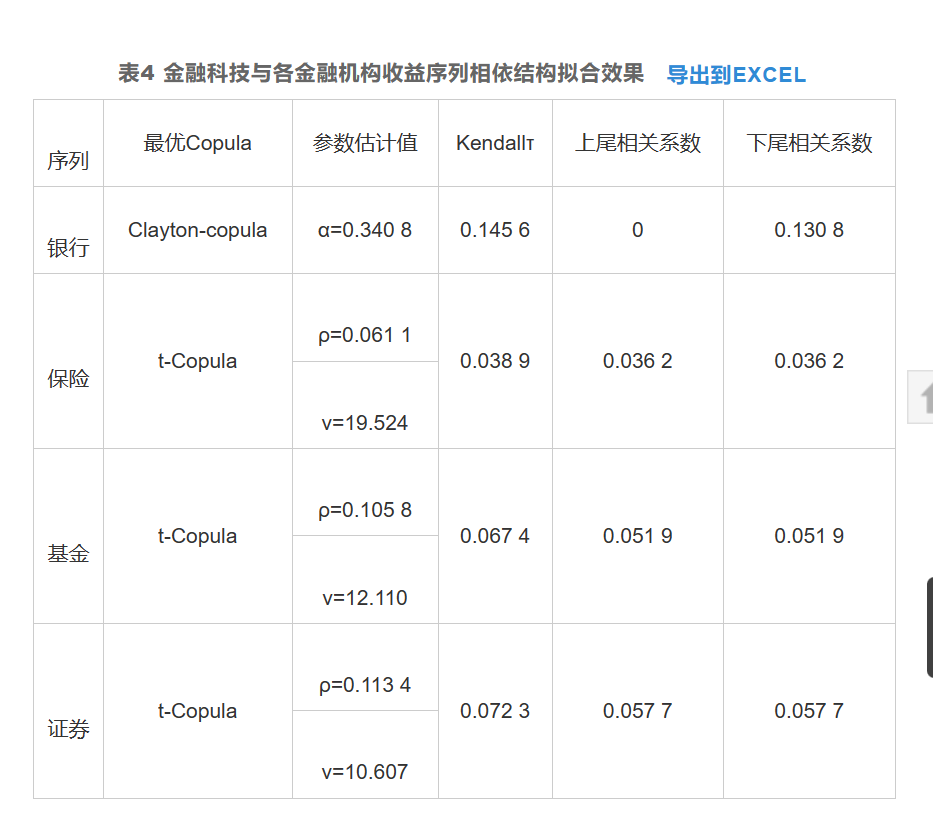